# 이름 : 나영훈
# 학번 : 20185124
--------------
<!-- #### Final Project 

### Project: Painting classification

### Due date: 2021.06.17

### 다음 링크로 접속하여 우선 팀 명을 바꿉니다. ex)20185141_용권순
https://www.kaggle.com/t/5d0dd41884af634cfe373b13b9fa6ee6

#### Data로 가서 Data를 모두 다운 받습니다. 그 다음은 Template code를 따라서 진행하시면 됩니다. 
>##### 최종실행 후  csv파일을 업로드 하시면 public결과가 보여집니다. 

---

* 아래 여러 셀에서 코드를 완성하는 부분을 수행하고, 보고서에 설명을 최대한 자세하게 적어주세요. 기준은 본인이 이해하고 있다는 것을 표현할 수 있는 부분을 모두 적으시면 됩니다.
  
  
> **제출방법**: 
* 보고서에는 코드 캡쳐 첨부이외에도, 각 코드를 작성하는 기반 이론, 방법론과 설명을 작성하세요.
--------------------------- -->

#### Final project 규칙
<!-- 
- 학생들 간의 질문은 금지합니다 (교수 및 조교에게 질문하세요)
- 대 원칙은 "내가 이해한 것만 활용하고 작성한다" 입니다
- 사용하는 기법들과 코드는 모두 보고서에 설명되어야하며, 설명이 없는 경우 감점이나 0점 처리합니다
    - 예를 들어서 검색한 끝에 model ensemble이라는 기법이 유용할 것 같아서, 참고하여 성능을 개선한 경우
        1. 참고자료의 출처를 작성할 것
        2. 기반 이론을 설명할 것
        3. 사용한 코드 분석 및 기법을 설명할 것
- 주석이 없는 경우 채점하지 않습니다
- <p style="color:red;">Pretrained network은 사용하지 않습니다. 본 프로젝트에서는, random 초기화한 parameter들을 직접 학습하는 과정만 허용합니다</p>

    - 랜덤 초기화 기법은 특별한 제약이 없습니다
- Competition 순위와 보고서는 각각 5:5로 점수가 반영됩니다.
------------------------

# 주의: 최종적으로 제출한 csv파일이 code에서 돌린 파일과 일치해야합니다. 
> + 기말 프로젝트 제출 시, model의 파라메터가 저장된 pt 파일, 보고서를 같이 제출합니다. 
> + 체점 과정 중 kaggle에 올라간 최종 csv파일과 제출한 모델을 사용하여 학생이 제출한 code로 csv생성 및 비교합니다(수기 변경 방지).
> + kaggle에 올라간 최종 csv파일과 학생이 제출한 code로 생성한 csv파일이 다를 경우 감점 요소가 생길 수 있으니 주의해주시길 바랍니다.

## 제출 하기 전 모든 셀을 정리해서 커널을 다시 실행하는 것을 권장  -->

---


#### 배경 설명
<!-- 
> #### 여러분은 유명한 화가의 작품을 전시하는 유명한 미술관에 취업했습니다. 
>#### 최근 미술관이 대량의 작품을 입수하여, 각 화가들의 전시회를 열려고 합니다.   
>#### 그러나 작품의 수가 너무나 많아서 사람이 분류하기에는 시간이 오래 걸릴것이라고 판단됩니다. 
>#### 이에 여러분은 딥러닝을 사용하여 효율적인 화가별 그림 분류 프로그램을 만들고자 합니다.

# 목표: 
> ### 본 프로젝트의 완성본은, 새로운 그림(Image)입력하면 <p style="color:red">해당 그림을 그린 화가를 예측합니다.</p> -->



## Step 0: Import library

- 필요하다 생각되는 라이브러리를 미리 import합니다. (참고)
- 필요 없는 라이브러리를 제거하거나 필요한 라이브러리를 추가하셔도 됩니다.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from time import time, ctime, localtime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset,DataLoader

import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision import models

import cv2

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,train_test_split
from sklearn.model_selection import StratifiedKFold,  KFold

import albumentations as A

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [3]:
# 참고한 사이트
#https://deeplizard.com/learn/video/lu7TCu7HeYc 
# https://yjs-program.tistory.com/151 ResNet

## Step 1: Preparing Dataset 
### 1-1: 경로 설정

In [4]:
#본인 컴퓨터에 맞는 train folder의 위치를 입력합니다.(string)
train_dir = './painting_resize_256/train'   

In [5]:
# 폴더의 목록(화가의 이름)을 가지고 옵니다. 총 class : 15개  + 1
classes = []

#class목록을 저장할 list 
for i in range(len(glob.glob(train_dir+'/*'))): #glob을 통해 list 목록을 모두 불러옵니다.
    classes.append(glob.glob(train_dir+'/*')[i].split('/')[-1])

# 리눅스 환경에서 작업할 경우 순서가 꼬이는 문제 발생 -> sorted() 한줄로 해결
classes = sorted(classes)  # Train 데이터의 label값과 classes의 순서가 다르기 때문에 sorted로 조절하였습니다.
class_num = len(classes)   # 총 라벨 데이터의 길이.
total_num = 0

classes_num = {e:0 for e in classes} # train 데이터의 칼럼(작가) 별 갯수를 알아보기 위해 선언. Dictionary Comprehention사용.
# 저는 클래스의 이름 뿐만 아니라 사진의 수도 알고 싶어서 다음과 같이 classes_num이란 변수를 만들어 확인을 하였습니다.
for idx in range(class_num):         
    classes_num[classes[idx]] = len(glob.glob(train_dir+ "/" + classes[idx] + "/*")) # 리스트 불러오는 주소에서 한번 더 들어가 클래스 별 갯수를 저장하였습니다.
    total_num += classes_num[classes[idx]]


# print를 통해 위에서 얻어온 값들을 출력합니다.
print('Total Class num: ',class_num)
print('Total Picture num: ',total_num)
print('Class label:')
for i in range(class_num):
    print('{:5d}th {:5d} picture : ' .format(i+1, classes_num[classes[i]]),classes[i])

Total Class num:  16
Total Picture num:  12851
Class label:
    1th   786 picture :  Albrecht_Du_rer
    2th   580 picture :  Andy_Warhol
    3th   483 picture :  Claude_Monet
    4th  1683 picture :  Edgar_Degas
    5th   648 picture :  Edouard_Manet
    6th   932 picture :  Francisco_Goya
    7th    76 picture :  Jackson_Pollock
    8th   574 picture :  Joan_Miro
    9th   798 picture :  Leonardo_da_Vinci
   10th   573 picture :  Marc_Chagall
   11th  1053 picture :  Pablo_Picasso
   12th  1345 picture :  Pierre-Auguste_Renoir
   13th   234 picture :  Piet_Mondrian
   14th   840 picture :  Rembrandt
   15th  2106 picture :  Vincent_van_Gogh
   16th   140 picture :  Z_Piet_Mondrian_Sq


### 1-2. 제대로 read 되는지 확인 (Transform적용)

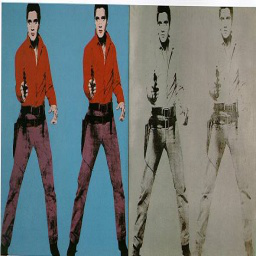

In [7]:
# check image 함수는 이미지가 잘 불러와지는지 확인하고 적용하는 함수
def check_Image(image_path,transform =None):
    image = Image.open(image_path).convert("RGB")
    # transform이 없다면 그냥 이미지 반환
    if transform ==None:
        return image    

    # transform이 있다면 적용해서 반환
    else: 
        return transform(image)

path = "./painting_resize_256/train"
image = path + "/Andy_Warhol/Andy_Warhol_1.jpg"
check_Image(image)

In [ ]:
image.png

## Data Augmentation

In [8]:
# 영상처리를 통한 이미지 Argumentation
# !pip install opencv-python
print('Class label:')
for i in range(class_num):
    print('idx : {:5d} {:5d} picture : ' .format(i, classes_num[classes[i]]),classes[i])

Class label:
idx :     0   786 picture :  Albrecht_Du_rer
idx :     1   580 picture :  Andy_Warhol
idx :     2   483 picture :  Claude_Monet
idx :     3  1683 picture :  Edgar_Degas
idx :     4   648 picture :  Edouard_Manet
idx :     5   932 picture :  Francisco_Goya
idx :     6    76 picture :  Jackson_Pollock
idx :     7   574 picture :  Joan_Miro
idx :     8   798 picture :  Leonardo_da_Vinci
idx :     9   573 picture :  Marc_Chagall
idx :    10  1053 picture :  Pablo_Picasso
idx :    11  1345 picture :  Pierre-Auguste_Renoir
idx :    12   234 picture :  Piet_Mondrian
idx :    13   840 picture :  Rembrandt
idx :    14  2106 picture :  Vincent_van_Gogh
idx :    15   140 picture :  Z_Piet_Mondrian_Sq


# Data Augmentation 

In [9]:
import albumentations as A
random.seed(0)

def Perspective(p = 1): # 원근 투영법 
    return A.Compose([ 
        A.Perspective(p = 1) # 원근 투영 -> 실제로 사용 안함
], p = p) 
            

def cut_out(p = 1):
    return A.Compose([ # cutout -> 구멍내는 방법 -> 구멍은 3개의 크기는 50x100사이즈
        # 초기 값은 8개의 1x1px 너무 작은 것 같아서 크게 늘려줌
        A.Cutout(num_holes = 3, max_h_size = 100, max_w_size = 50, p = 1)
], p = p) 

def random_gridshuffle(p = 1):
    return A.Compose([ # RandomGridShuffle 3x3 형태로 잘라서 섞어줌
        A.RandomGridShuffle(grid=(3,3), p=1)
], p = p) 

def MultiplicativeNoise(p = 1):
    return A.Compose([ # Noise를 만들어주는 함수, 최대한 세게 설정을 했지만 사용하진 않음
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, p=1)
], p = p) 

def JpegCompression(p = 1):
    return A.Compose([ # 화질을 낮춰주는 변환
        A.JpegCompression(quality_lower=0, quality_upper=1, p=1)
], p = p) 

def channelShuffle(p =1):
        return A.Compose([ #RGB 채널을 무작위로 섞는 방법
        A.ChannelShuffle(p = 1)
], p = p) 



### Albrecht_Du_rer

In [11]:
random.seed(0)

Albrecht_Du_rer_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Albrecht_Du_rer'
# len_pollck = len(glob.glob(Jackson_Pollck_dir + "/*")) 
len_Albrecht = 328 # 328 보다 클 경우 계속 실행시 마다 덮어씌워짐, 이미지의 마지막 번호 
tw = 2 # 반복 횟수
for t in range(1, tw+1):
    for i in range(len_Albrecht):

        # 이미지를 읽는 방법 위에서 PIL 이미지를 읽는 방법을 참고함.
        img_path = Albrecht_Du_rer_dir + "/Albrecht_Du_rer_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue # 중간중간 이미지가 비어있을 경우 읽으면 오류가 뜨기 때문에 Continue로 처리
        
        # 랜덤 넘버, 이미지를 다양한 방법으로 늘려주기 
        augmentation_number = np.random.randint(1, 3)

        if  t == 1:  #RandomHorizontalFlip을 사용하여 좌우 반전 혹은 ColorJitter를 이용한 색상 변횐
            if augmentation_number == 1: trans = transforms.RandomHorizontalFlip(p = 1) 
            elif augmentation_number == 2:trans = transforms.ColorJitter(hue = 0.5, contrast=0.3)

            image = trans(image) # 이미지 적용 방법.
            
            save_file_name = Albrecht_Du_rer_dir + "/Albrecht_Du_rer_" + str(len_Albrecht * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg") 

        elif t == 2: # 2번째 반복에서는 Cutout과 RandomGridshuffle 적용
            if augmentation_number == 1:
                image = np.array(image) # albumtation 적용 위해 numpy ndarray형변환. 안하면 오류..
                aug_grid = cut_out(p=1)

            elif augmentation_number == 2:
                image = np.array(image)
                aug_grid = random_gridshuffle(p=1)


            # albumtation github 참조 
            # https://github.com/albumentations-team/albumentations_examples
            data = {'image':image} # data를 dictionary형태로 저장, 이름과 이름에 해당 하는 데이터
            aug_img = aug_grid(**data) # 이미지에 적용된 transform 적용
            image = aug_img['image']   # 적용된 transform이 dictionary형태 이므로 image 지정
            image=Image.fromarray(image) # PIL 폼으로 다시변환 -> 저장 양식이 PIL 이라서

            save_file_name = Albrecht_Du_rer_dir + "/Albrecht_Du_rer_" + str(len_Albrecht * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

    print("Augmantation Finish")   


Augmantation Finish
Augmantation Finish


### Andy_Warhol

In [85]:
random.seed(0) # 랜덤 시드 고정 
Andy_Warhol_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Andy_Warhol'
len_Andy = 181 # 앤디 워홀의 마지막 이미지 번호는 181
tw = 3 # 반복 횟수 

for t in range(1, tw+1): 
    for i in range(len_Andy):
        # 이미지를 읽어서 PIL 이미지로 저장하는 과정 만약 이미지가 없다면 Continue로 패스
        img_path = Andy_Warhol_dir + "/Andy_Warhol_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        # 무작위 랜덤 번호 생성
        augmentation_number = np.random.randint(1, 3)

        if t == 1: trans = transforms.RandomHorizontalFlip(p = 1) # 좌우 반전 p = 1 로 줘서 모두 반전 시킴
        elif t == 3: trans = transforms.ColorJitter(hue=0.5, saturation=0.3) # hue  = 0.5로 색상을 조절 
        # 최대 값은 0부터 0.5까지 

        elif t == 2: # 2번 째 반복은 Albumtation 사용
            if augmentation_number == 1:
                image = np.array(image) # 이미지를 Numpy Array로 바꿔줘야 Albumtation 사용 가능함.
                aug_grid = cut_out(p=1) # cut_out 기법을 사용함. -> 중간 중간 구멍을 뚫어줌 GaussianNosise와는 다름

            elif augmentation_number == 2: 
                image = np.array(image) # 이미지를 Numpy Array로 바꿔줘야 Albumtation 사용 가능함.
                aug_grid = channelShuffle(p=1) # RandomGridShuffle 사용 -> 3x3로 나눠서 섞음

            elif augmentation_number == 3:
                image = np.array(image) # 이미지를 Numpy Array로 바꿔줘야 Albumtation 사용 가능함.
                aug_grid = random_gridshuffle(p=1) # RandomGridShuffle 사용 -> 3x3로 나눠서 섞음


        if t==1 or t==3:
            image = trans(image) # transform 적용
        else:
            # albumtation 적용 과정 
            # 참고 링크 https://github.com/albumentations-team/albumentations_examples에서 나에게 맞게 적용
            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

        # 파일 저장 181 x 반복 횟수 x + 현재 이미지의 번호 + 1 
        save_file_name = Andy_Warhol_dir + "/Andy_Warhol_" + str(len_Andy * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")
    print("Augmentation Finish")


Augmentation Finish


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Augmentation Finish
Augmentation Finish


### Claude_Monet

In [57]:
random.seed(20220512) # 랜덤 시드 고정 : 현재 날짜
Monet_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Claude_Monet' # 위치
len_monet = 73  # 모네 그림의 마지막 index는 73
tw = 7 # 반복 횟수 -> 그림이 적기 때문에 Claude Monet의 Loss차이가 많이 나더라도
# 데이터 수가 많은 반 고흐나 다른 친구쪽에 맞춰 Loss 개선이 될 것 같다는 생각을 함 -> 수를 늘려줘서 극복하자

for t in range(1, tw + 1): 
    for i in range(len_monet):
        # 이미지를 읽어서 PIL 이미지로 저장하는 과정 만약 이미지가 없다면 Continue로 패스
        img_path = Monet_dir + "/Claude_Monet_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue

        # Data Augmentations 적용 코드, 좌우반전, 색상변환, 상하반전,  회전
        if t == 1: trans = transforms.RandomHorizontalFlip(p = 1)
        elif t == 4: trans = transforms.ColorJitter(hue=0.5, saturation= 0.5)
        elif t == 5: trans = transforms.RandomVerticalFlip(p = 1)
        elif t == 6:trans = transforms.RandomRotation(degrees=45)
        elif t == 7:
            image = np.array(image)
            aug = channelShuffle(p=1) #channelShuffle -> 효과 없음 대체 했어야 하는데...
            
        elif t == 2:
            image = np.array(image)
            aug = cut_out(p=1) # cutout과 randomGridshuffle 성능은 확실함.
            
        elif t == 3:
            image = np.array(image)
            aug = random_gridshuffle(p=1)

        # albumtation 사용시 변환
        if t == 2 or t == 3 or t == 7:
            data = {'image':image}
            aug_img = aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)
        else: image = trans(image) # 여기는 기존의 transform 사용시 변환
        save_file_name = Monet_dir + "/Claude_Monet_" + str(len_monet * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Aug Fin")

Aug Fin


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Aug Fin
Aug Fin
Aug Fin
Aug Fin
Aug Fin
Aug Fin


### Edgar_Degas

In [12]:
random.seed(0)
Edgar_Degas_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Edgar_Degas'
len_Edgar_Degas = 702 # 702가 이미지의 마지막 번호
tw = 2 # 반복

for t in range(1, tw+1):
    for i in range(len_Edgar_Degas):

        img_path = Edgar_Degas_dir + "/Edgar_Degas_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue

        # 좌우반전, 색변환 적용
        if t == 1:
            augmentation_number = np.random.randint(1, 3) 
            if augmentation_number == 1: trans = transforms.RandomHorizontalFlip(p = 1)
            elif augmentation_number == 2: trans = transforms.ColorJitter(hue = 0.5)
            
                

            image = trans(image)

        # Cutout GridShuffle channelShuffle 적용
        elif t == 2:
            augmentation_number = np.random.randint(1, 5) # 대략 600장에 가까운 이미지를 다 늘려주기엔
            # 너무 많다고 생각함.
            
            image = np.array(image)
            if augmentation_number == 1:    aug_grid = cut_out(p=1)
            elif augmentation_number == 2:  aug_grid = random_gridshuffle(p=1)
            elif augmentation_number == 3:  aug_grid = channelShuffle(p=1)
            else: continue
                

            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)


        save_file_name = Edgar_Degas_dir + "/Edgar_Degas_" + str(len_Edgar_Degas * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Aug fin")

Aug fin
Aug fin


### Edouard_Manet Data Augmentation

In [13]:
random.seed(0)

Edouard_Manet_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Edouard_Manet'
len_Edouard_Manet = 90 
tw = 8 #마네도 마찬가지로 수가 적기 때문에 늘려줌

for t in range(1, tw+1):
    for i in range(len_Edouard_Manet):

        img_path = Edouard_Manet_dir + "/Edouard_Manet_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue

        # cut-out 
        if t == 1:
            image = np.array(image)
            aug = cut_out(p=1)

        elif t == 2: # gridshuffle
            image = np.array(image)
            aug = random_gridshuffle(p=1)

        # 여러가지 transform 적용
        elif t == 3: trans = transforms.RandomRotation(degrees=40)
        elif t == 4: trans = transforms.ColorJitter(hue = 0.5)
        elif t == 5: trans = transforms.RandomVerticalFlip(p = 1)
        elif t == 6: trans = transforms.RandomHorizontalFlip(p = 1)
        elif t == 7:  # 채널 셔플 성능 별로기 때문에 여기서는 Jpeg변환 및 노이즈 사용
            image = np.array(image) #JpegCompression 화질 낮추기
            aug = JpegCompression(p = 1)
        elif t == 8:
            image = np.array(image)
            aug = MultiplicativeNoise(p=1) # Noise 생성

        if t==1 or t==2 or t == 7 or t == 8:
            data = {'image':image}
            aug_img = aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

        else:
            image = trans(image)
            
        save_file_name = Edouard_Manet_dir + "/Edouard_Manet_" + str(len_Edouard_Manet*t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Augmentation Fin")   

Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


Augmentation Fin
Augmentation Fin


### Claude_Monet 데이터 Augmentation2 매우 초창기 opencv를 사용하여 증강시켜줌

In [14]:
# Monet_dir = '/home/nyh/kaggle/Final project_/painting_resize_256/train/Claude_Monet'
# len_monet = len(glob.glob(Monet_dir + "/*"))
# len_monet = 73 

# for i in range(len_monet):

#     img_path = Monet_dir + "/Claude_Monet_" + str(i+1) + ".jpg"
#     image = cv2.imread(img_path)
#     if image is None: 
#         continue
    
#     argument_num = np.random.randint(1, 4)

#     if argument_num == 1:
#         image = cv2.flip(image,  0) # x축 기준 뒤집기
    
#     elif argument_num == 2:
#         image = cv2.flip(image,  1) # y축 기준 뒤집기

#     elif argument_num == 3:
#         image = cv2.flip(image,  -1) # x축한번 y축 한번 뒤집기

     
#     cv2.imwrite(Monet_dir + "/Claude_Monet" + str(len_monet + i + 1) + ".jpg", image)


# Monet_dir = '/home/nyh/kaggle/Final project_/painting_resize_256/train/Claude_Monet'
# len_monet = len(glob.glob(Monet_dir + "/*"))
# # print(len_monet)
# len_monet = 73 

# for i in range(len_monet):

#     img_path = Monet_dir + "/Claude_Monet_" + str(i+1) + ".jpg"
#     image = cv2.imread(img_path)
#     if image is None: 
#         continue
    

#     image = Image.open(img_path).convert("RGB")
#     argument_num = np.random.randint(4, 6)

#     if argument_num == 4:
#         # image = cv2.GaussianBlur(image, (5,5), 0) # 가우시안 블러딩을 통한 이미지 생성.   
#         trans = transforms.GaussianBlur(kernel_size=5)
#         image = trans(image)
    
#     elif argument_num == 5:
#         trans = transforms.RandomRotation(40)
#         image = trans(image)

#     save_file_name = Monet_dir + "/Claude_Monet_" + str(len_monet*2 + i + 1) + ".jpg"
#     # print(save_file_name)
#     image.save(save_file_name, "jpeg")

### Francisco_Goya

In [17]:
random.seed(0)

Francisco_Goya_dir = "/home/nyh/kaggle/Final project_33/painting_resize_256/train/Francisco_Goya"
len_Francisco_Goya = 291
tw = 3

for t in range(1, tw+1):
    for i in range(len_Francisco_Goya):

        img_path = Francisco_Goya_dir + "/Francisco_Goya_" + str(i+1) + ".jpg"

        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        augmentation_number = np.random.randint(1, 3)


        if t==1:     
            if augmentation_number == 1:       
                image = np.array(image)
                aug_cut = cut_out(p=1)

                
            elif augmentation_number == 2:
                image = np.array(image)
                aug_grid = random_gridshuffle(p=1)


            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Francisco_Goya_dir + "/Francisco_Goya_" + str(len_Francisco_Goya * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

        elif t == 2:
            if augmentation_number == 1:
                trans = transforms.RandomVerticalFlip(p = 1)
        
            elif augmentation_number == 2:
                trans = transforms.RandomHorizontalFlip(p = 1)

        elif t == 3: trans = transforms.ColorJitter(hue=0.5)
            

        if t == 2 or t == 3:
            image = trans(image)
            save_file_name = Francisco_Goya_dir + "/Francisco_Goya_" + str(len_Francisco_Goya * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")


    print("augmentation Fin")


augmentation Fin
augmentation Fin
augmentation Fin


### Jackson_Pollck

In [18]:
random.seed(9)
Jackson_Pollck_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Jackson_Pollock'
# len_pollck = len(glob.glob(Jackson_Pollck_dir + "/*")) 
len_pollck = 24 # 24 보다 클 경우 계속 실행시 마다 덮어씌워짐

tw = 3
for t in range(1, tw+1):
    for i in range(len_pollck):
        img_path = Jackson_Pollck_dir + "/Jackson_Pollock_" + str(i+1) + ".jpg"

        try: image = Image.open(img_path).convert("RGB")
        except: continue

        augmentation_number = np.random.randint(1,3)

        if t == 1: 
            
            if augmentation_number == 1: trans = transforms.RandomVerticalFlip(p = 1)        
            elif augmentation_number == 2: trans = transforms.RandomHorizontalFlip(p=1)     
        elif t == 2: trans = transforms.ColorJitter(hue=0.5, saturation=0.5, contrast=0.5)
        elif t == 3: 
            image = np.array(image)
            aug_grid = cut_out(p=1)

            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Jackson_Pollck_dir + "/Jackson_Pollock_" + str(len_pollck*t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue

        image = trans(image)
    
        save_file_name = Jackson_Pollck_dir + "/Jackson_Pollock_" + str(len_pollck*t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")
        
    print("Aug Fin")

Aug Fin
Aug Fin
Aug Fin


###  Joan_Miro

In [19]:
Joan_Miro_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Joan_Miro'
len_miro = 102 #마지막 인덱스
tw = 6

for t in range(1, tw+1):
    for i in range(len_miro):

        img_path = Joan_Miro_dir + "/Joan_Miro_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        

        if t == 1: trans = transforms.RandomHorizontalFlip(p=1)        
        elif t == 2: trans = transforms.RandomVerticalFlip(p=1)
        elif t == 3: trans = transforms.ColorJitter(hue = 0.5)
        elif t == 4:
            image = np.array(image)
            aug_grid = cut_out(p=1)
        elif t == 5:
            image = np.array(image)
            aug_grid = random_gridshuffle(p=1)
        elif t == 6: trans = transforms.GaussianBlur(kernel_size=5)
        
        
        if t==1 or t==2 or t==3 or t == 6:
            image = trans(image)
        elif t==4 or t==5:
            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

        save_file_name = Joan_Miro_dir + "/Joan_Miro_" + str(len_miro*t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")
        
    print("Aug Fin")

Aug Fin
Aug Fin
Aug Fin
Aug Fin
Aug Fin
Aug Fin


### Leonardo_da_Vinci

In [20]:
da_Vinci_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Leonardo_da_Vinci'
len_da_vinci = 143 #마지막 인덱스
random.seed(0)
tw = 6

for t in range(1, tw+1):
    for i in range(len_da_vinci):

        img_path = da_Vinci_dir + "/Leonardo_da_Vinci_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        if t==1: trans = transforms.RandomVerticalFlip(p = 1)
        elif t == 2:  trans = transforms.RandomVerticalFlip(p = 1)
        elif t == 3: trans = transforms.ColorJitter(hue= 0.5)
        elif t == 4:
            image = np.array(image)
            aug_grid = cut_out(p=1)
            
        elif t == 5:
            image = np.array(image)
            aug_grid = random_gridshuffle(p=1)

        elif t == 6: trans = transforms.GaussianBlur(kernel_size=(3,3))

        if t == 1 or t == 2 or t == 3 or  t == 6: image = trans(image)
            
        else:
            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

        save_file_name = da_Vinci_dir + "/Leonardo_da_Vinci_" + str(len_da_vinci * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")


            
    print("augmentation Fin")


augmentation Fin
augmentation Fin
augmentation Fin
augmentation Fin
augmentation Fin
augmentation Fin


## Marc_Chagall

In [21]:
random.seed(0)

Marc_Chagall_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Marc_Chagall'
len_Marc_Chagall = 239
tw = 2
for t in range(1, tw+1):
    for i in range(len_Marc_Chagall):

        img_path = Marc_Chagall_dir + "/Marc_Chagall_" + str(i+1) + ".jpg"

        try: image = Image.open(img_path).convert("RGB")
        except: continue

        argument_num = np.random.randint(1, 5)

        if t == 1:
            if argument_num == 1: trans = transforms.RandomVerticalFlip(p = 1)
            elif argument_num == 2: trans = transforms.RandomHorizontalFlip(p = 1)
            image = trans(image)

            save_file_name = Marc_Chagall_dir + "/Marc_Chagall_" + str(len_Marc_Chagall * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

        elif t == 2:
            if augmentation_number == 1:       
                image = np.array(image)
                aug_cut = cut_out(p=1)

                
            elif augmentation_number == 2:
                image = np.array(image)
                aug_grid = random_gridshuffle(p=1)


            data = {'image':image}
            aug_img = aug_grid(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Marc_Chagall_dir + "/Marc_Chagall_" + str(len_Marc_Chagall * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

    print("Augmentation Finish")
        

Augmentation Finish
Augmentation Finish


## Pablo_Picasso

In [12]:
random.seed(0)
Piccaso_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Pablo_Picasso'
len_Piccaso = 438
tw = 2

for t in range(1, tw+1):
    for i in range(len_Piccaso):

        img_path = Piccaso_dir + "/Pablo_Picasso_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue


        augmentation_number = np.random.randint(1, 3)

        if t==1: 
            if augmentation_number == 1:
                trans = transforms.RandomHorizontalFlip(p = 1)
            elif augmentation_number == 2:
                trans = transforms.ColorJitter(hue = 0.5)
            else:
                continue

        elif t == 2:

            if augmentation_number == 1:
                image = np.array(image)
                aug = cut_out(p=1)

            elif augmentation_number == 2:
                image = np.array(image)
                aug = random_gridshuffle(p=1)

        if t == 1:
            image = trans(image)

            save_file_name = Piccaso_dir + "/Pablo_Picasso_" + str(len_Piccaso*t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

        elif t == 2:
            data = {'image':image}
            aug_img = aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Piccaso_dir + "/Pablo_Picasso_" + str(len_Piccaso*t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")



    print("Augmentation Fin")

Augmentation Fin


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Augmentation Fin


## Pierre-Auguste_Renoir

In [23]:
random.seed(22)
Renoir_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Pierre-Auguste_Renoir'
len_Renoir = 336
tw = 4

for t in range(1, tw+1):
    for i in range(len_Renoir):

        img_path = Renoir_dir + "/Pierre-Auguste_Renoir_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        augmentation_number = np.random.randint(1, 3)

        if t == 1:  
            trans = transforms.RandomHorizontalFlip(p = 1)
        elif t == 2: 
            image = np.array(image)
            cut_out_aug = random_gridshuffle(p=1)
            data = {'image':image}
            aug_img = cut_out_aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Renoir_dir + "/Pierre-Auguste_Renoir_" + str(len_Renoir * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue
            

        elif t == 3: trans = transforms.ColorJitter(hue = 0.5, contrast=0.3)
        elif t == 4: 
            image = np.array(image)
            cut_out_aug = cut_out(p=1)
            data = {'image':image}
            aug_img = cut_out_aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Renoir_dir + "/Pierre-Auguste_Renoir_" + str(len_Renoir * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue
            

        image = trans(image)

        save_file_name = Renoir_dir + "/Pierre-Auguste_Renoir_" + str(len_Renoir*t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Augmentation Fin")

Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin


### Piet_Mondrian , 특이한 그림과 특이하게 생기지 않은 그림 분류

In [24]:
import albumentations as A
random.seed(0)

Piet_Mondrian_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Piet_Mondrian'
len_Mondrian = 84
tw = 5

for t in range(1, tw+1):
    for i in range(len_Mondrian):

        img_path = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        augmentation_number = np.random.randint(1,3)
        if t == 1:  
            if augmentation_number == 1:
                trans = transforms.RandomHorizontalFlip(p = 1)
            else: trans = transforms.RandomVerticalFlip(p = 1)

        elif t == 2: 
            trans = transforms.GaussianBlur(kernel_size=5, sigma = (0.5 , 10))
        elif t==3:
            trans = transforms.RandomRotation(degrees=40)

        elif t==4:     
            if augmentation_number == 1:       
                image = np.array(image)
                cut_out_aug = cut_out(p=1)
                data = {'image':image}
                aug_img = cut_out_aug(**data)
                image = aug_img['image']
                image=Image.fromarray(image)

                save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
                image.save(save_file_name, "jpeg")

                continue
                
        elif t== 5:
            image = np.array(image)
            gau_no = random_gridshuffle(p=1)
            data = {'image':image}
            aug_img = gau_no(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue


        image = trans(image)

        save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Augmentation Fin")

Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin
Augmentation Fin


In [38]:
random.seed(0)
Piet_Mondrian_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Z_Piet_Mondrian_Sq'
len_Mondrian = 84
tw = 4

for t in range(1, tw+1):
    for i in range(len_Mondrian):

        img_path = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
        
        augmentation_number = np.random.randint(1, 3)

        if t == 1:  
            if augmentation_number == 1: trans = transforms.RandomHorizontalFlip(p = 1)
            else : trans = transforms.RandomVerticalFlip(p = 1)
        elif t == 2: 
    
            image = np.array(image)
            cut_out_aug = cut_out(p=1)
            data = {'image':image}
            aug_img = cut_out_aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue

        elif t == 3:
            trans = transforms.RandomRotation(45)
        
        elif t == 4:
            image = np.array(image)
            gau_no = random_gridshuffle(p=1)
            data = {'image':image}
            aug_img = gau_no(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
            image.save(save_file_name, "jpeg")

            continue

        image = trans(image)

        save_file_name = Piet_Mondrian_dir + "/Piet_Mondrian_" + str(len_Mondrian * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Augmentation", t , "th Fin")

Augmentation 1 th Fin
Augmentation 2 th Fin
Augmentation 3 th Fin


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Augmentation 4 th Fin


## Rembrandt

In [26]:
random.seed(0)
Rembrandt_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Rembrandt'
len_Rembrandt = 262
tw = 2

for t in range(1, tw+1):
    for i in range(len_Rembrandt):

        img_path = Rembrandt_dir + "/Rembrandt_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue
            

        if t == 1:
            augmentation_number = np.random.randint(1, 4)    
            if augmentation_number == 1:  trans = transforms.RandomHorizontalFlip(p = 1)
            elif augmentation_number == 2: trans = transforms.RandomVerticalFlip(p = 1)
            elif augmentation_number == 3: trans = transforms.GaussianBlur(kernel_size=5)

            image = trans(image)
        
        elif t == 2:
            augmentation_number = np.random.randint(1, 3)
            if augmentation_number == 1:
                image = np.array(image)
                cut_out_aug = cut_out(p=1)
            elif augmentation_number == 2:
                image = np.array(image)
                cut_out_aug = random_gridshuffle(p=1)

            data = {'image':image}
            aug_img = cut_out_aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)           

        save_file_name = Rembrandt_dir + "/Rembrandt_" + str(len_Rembrandt * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")

    print("Augmentation Fin")

Augmentation Fin
Augmentation Fin


## Vincent_van_Gogh

In [11]:
random.seed(42) # 랜덤 시드 42 있어보이게
Vincent_van_Gogh_dir = '/home/nyh/kaggle/Final project_33/painting_resize_256/train/Vincent_van_Gogh'
len_Vincent_van_Gogh = 877 #마지막 인덱스

tw = 2
for t in range(1, tw+1):
    for i in range(len_Vincent_van_Gogh):

        img_path = Vincent_van_Gogh_dir + "/Vincent_van_Gogh_" + str(i+1) + ".jpg"
        try: image = Image.open(img_path).convert("RGB")
        except: continue

        augmentation_number = np.random.randint(1, 3)

        if t == 1: 
            if augmentation_number == 1: trans = transforms.RandomHorizontalFlip(p = 1)
            elif augmentation_number == 2 : trans = transforms.ColorJitter(hue = 0.5)
        
            image = trans(image)



                
        elif t == 2: 

            if augmentation_number == 1 :
                image = np.array(image)
                aug = cut_out(p=1)
            elif augmentation_number == 2 : 
                image = np.array(image)
                aug = random_gridshuffle(p=1)

            data = {'image':image}
            aug_img = aug(**data)
            image = aug_img['image']
            image=Image.fromarray(image)

            

        save_file_name = Vincent_van_Gogh_dir + "/Vincent_van_Gogh_" + str(len_Vincent_van_Gogh * t + i + 1) + ".jpg"
        image.save(save_file_name, "jpeg")
    print("Augmentation fin")

Augmentation fin


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Augmentation fin


# Step2: Generating DataLoader for Dataset

#### 평균을 구해 초기화 해주는 방식

In [28]:
# meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_set] #RGB 채널별 평균 구하기
# stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_set]   #RGB 채널별 표준편차 구하기

# # rgb별 채널별로 평균 요약
# meanR = np.mean([m[0] for m in meanRGB])  
# meanG = np.mean([m[1] for m in meanRGB])
# meanB = np.mean([m[2] for m in meanRGB])

# # rgb별 채널별로 표준편차 요약
# stdR = np.mean([s[0] for s in stdRGB])
# stdG = np.mean([s[1] for s in stdRGB])
# stdB = np.mean([s[2] for s in stdRGB])

# # 평균 분산 넣어주기.
# print(meanR, meanG, meanB)
# print(stdR, stdG, stdB)

### DataLoader

In [10]:
data_dir = './painting_resize_256/'   

train_transforms = transforms.Compose([
                                          transforms.RandomResizedCrop(224), #VGG의 입력 이미지 차원은  3x224x224
                                          # transforms.RandomCrop(224),
                                          # transforms.RandomResizedCrop(256), # VGG보다 성능좋은 실습모델 3x256x256 입력!
                                        
                                       transforms.ToTensor(), # Tensor 형태로 변환
                                       # Normalize는 train과 test가 같아야함
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                                       # 이 코드의 수치는 많은 데이터를 가지고 있으며 모델의 성능평가에 쓰이는 ImageNet 데이터 셋에서 뽑아낸 평균과 표준편차이므로 위의 데이터를 사용하겠습니다.


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir +'/train', transform=train_transforms)

In [11]:
train_data , train_data.class_to_idx

(Dataset ImageFolder
     Number of datapoints: 12851
     Root location: ./painting_resize_256//train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 {'Albrecht_Du_rer': 0,
  'Andy_Warhol': 1,
  'Claude_Monet': 2,
  'Edgar_Degas': 3,
  'Edouard_Manet': 4,
  'Francisco_Goya': 5,
  'Jackson_Pollock': 6,
  'Joan_Miro': 7,
  'Leonardo_da_Vinci': 8,
  'Marc_Chagall': 9,
  'Pablo_Picasso': 10,
  'Pierre-Auguste_Renoir': 11,
  'Piet_Mondrian': 12,
  'Rembrandt': 13,
  'Vincent_van_Gogh': 14,
  'Z_Piet_Mondrian_Sq': 15})

## 밑에서 Kfold 사용시  자동으로 분할 해주기 때문에 주석 처리 해놓고 넘어감.

In [41]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler # 실습 때 사용하였던 SubsetRandomSampler 사용

train_size = 0.9 # train size 0.9 , validation size = 0.1
num_train = len(train_data) # train_data의 크기를 저장 
indices = list(range(num_train)) # train_Data 크기에 맞는 인덱스 생성 
np.random.shuffle(indices)   #  인덱스를 섞어야 라벨과 데이터가 안섞임
split = int(np.floor(train_size * num_train)) # 학습 데이터의 비율과 총 데이터의 크기를 곱한다음 np.floor를 통해 버림을 합니다.
train_idx, valid_idx = indices[:split], indices[split:] # 이제 split 된 크기만큼 train과 validation 데이터 셋을 나눠 줍니다. 
 # 이제 나눈 인덱스의 번호로 SubsetSampler를 통해 넣어줍니다
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [89]:
batchsize = 128 # 배치사이즈는 되도록이면 크게 가져가기위해 노력했습니다. 
# 배치사이즈가 커질 수록 연산량도 많아지기 때문에 GPU 용량이 많이 부족합니다.
# 하지만 데이터의 편차가 큰 상황에서 배치사이즈를 작게 해주면 그만큼 샘플이 작은 데이터는 들어가기 힘들것이고,
# 결국 결과는 샘플 수가 많은 모델쪽으로 학습이 될 수밖에 없다고 생각하였습니다. 따라서 이를 방지하기 위해
# StratifiedKFold 및 DataAugmentation을 사용하지만 배치 사이즈가 더 크면 수월하게 Loss가 줄어들 것이라 생각했습니다.

# DataLoader : Transforms 형태를 변환해주는 라이브러리.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=valid_sampler)

--------------------------

## Step 3: Generating Neural Network(model) 
 - <p style="color:red;">Pretrained network은 사용하지 않습니다. 본 프로젝트에서는, random 초기화한 parameter들을 직접 학습하는 과정만 허용합니다</p>
 - 모델을 선정한 이유를 간략하게 정리합니다.

#### torchvision 에서 Pretrain models import 

In [174]:
# from torchvision import models
# model = models.inception_v3(pretrained=False)
# model = models.googlenet(pretrained=False)
# print(model)

In [ ]:
# from torchvision import models

# model = models.vgg11(pretrained=False)
# print(model)

# model.fc = nn.Sequential(
#     nn.Linear(2048, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(1024, 15)
# )
# model.classifier = nn.Sequential(nn.Linear(25088, 4096),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.5),
#                                  nn.Linear(4096, 4096),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.5),
#                                  nn.Linear(4096, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.5),
#                                  nn.Linear(1024, 1024),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.5),
#                                  nn.Linear(1024, ),
#                                  )

In [175]:
# model = models.resnet18(pretrained=False)
# model.fc = nn.Linear(512, 16)
# model

# # from torchvision import models

# # model = models.resnet101(pretrained=False)
# # # model.layer4 = None
# # # model.fc = nn.Linear(2048, 15)
# # print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Inception 구현 도전하다가 포기.. 모델이 깊으면 학습이 안되기 때문

In [34]:
# import torch.nn as nn
# import torch.nn.functional as F

# # define the CNN architecture
# class Inception(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # convolutional layer (sees 3x32x32 image tensor)
#         self.conv = nn.Conv2d(3, 64, 7, stride = 2)
#         self.maxpool = nn.MaxPool2d(3, stride = 2)
#         self.conv1 = nn.Conv2d(64, 192, 3, stride = 1, padding=1)
#         self.maxpool = nn.MaxPool2d(3, stride = 2)


#         self.conv1_1 = nn.Conv2d(3, 64, 1, stride = 1, padding = 1)
#         self.conv2_1 = nn.Conv2d(3, 96, 1, stride = 1, padding = 1)
#         self.conv2_2 = nn.Conv2d(96, 128, 3, stride=1, padding=1)
#         self.conv3_1 = nn.Conv2d(3, 16, 1, stride=1, padding=1)
#         self.conv3_2 = nn.Conv2d(16, 32, 5, stride=1, padding=1)
#         self.pool4_1 = nn.MaxPool2d(3, stride=1)
#         self.conv4_2 = nn.Conv2d(3, 32, 1, stride=1, padding=1)
#         # self.conv22 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
#         # convolutional layer (sees 32x8x8 tensor)
#         self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
#         self.conv4 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)
#         self.conv44 = nn.Conv2d(256, 256, 3, stride = 1, padding = 1)

#         self.conv5 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
#         self.conv55 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)

#         self.batchnorm2d8 = nn.BatchNorm2d(8)
#         self.batchnorm2d16 = nn.BatchNorm2d(16)
#         self.batchnorm2d32 = nn.BatchNorm2d(32)
#         self.batchnorm2d64 = nn.BatchNorm2d(64)
#         self.batchnorm2d128 = nn.BatchNorm2d(128)
#         self.batchnorm2d256 = nn.BatchNorm2d(256)
#         self.batchnorm2d512 = nn.BatchNorm2d(512)



#         self.batchnorm1d512 = nn.BatchNorm1d(512)


#         self.InstanceNorm512 = nn.InstanceNorm1d(512)
#         # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274

        
#         # self.batchnorm1d1024 = nn.BatchNorm1d(1024)

#         # self.conv5 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)
#         # max pooling layer
#         # 32x16384
#         self.pool = nn.MaxPool2d(2, stride = 2)
#         # linear layer (64 * 4 * 4 -> 500)
#         # self.fc1 = nn.Linear(12544*4, 512)
#         self.fc1 = nn.Linear(16384 * 2, 512)

        
#         # 32768 = 512 * 8 * 8
#         # 32768 = 256 * 
#         # 32x65536 
#         # 32x262144 
#         # 32x
#         # linear layer (500 -> 10)
#         # self.fc2 = nn.Linear(4096, 512)
#         self.fc3 = nn.Linear(512, 15)
#         # dropout layer (p=0.25)
#         self.dropout = nn.Dropout(0.25)
#         self.relu = nn.ReLU(True)

#     def forward(self, x):
#         print(x.shape)
#         x = self.conv(x)
#         print(x.shape)
#         x = self.conv1(x)
#         print(x.shape)
#         x = self.maxpool(x)
#         print(x.shape)

#         print(x.shape)
#         first = self.conv1_1(x)
#         two = self.conv2_1(x)
#         two = self.conv2_2(two)
#         third = self.conv3_1(x)
#         third = self.conv3_2(third)
#         four = self.pool4_1(x)
#         four = self.conv4_2(four)

#         print(first.shape, two.shape, third.shape, four.shape)
#         layer1 = torch.vstack([first, two, third, four])

#         print(layer1.shape)

#         return layer1

# # create a complete CNN
# model = Inception()
# # move tensors to GPU if CUDA is available
# # model.to(device)

### 초창기 사용했던 4층짜리 CONVNET

In [61]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()

            # Conv Layer 쌓기
#         self.conv1 = nn.Conv2d(3, 32, 3, stride = (1,1), padding= 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
#         self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
#         self.conv4 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)

            # BatchNorm 은 필수
#         self.batchnorm2d32 = nn.BatchNorm2d(32)
#         self.batchnorm2d64 = nn.BatchNorm2d(64)
#         self.batchnorm2d128 = nn.BatchNorm2d(128)
#         self.batchnorm2d256 = nn.BatchNorm2d(256)

#         self.InstanceNorm512 = nn.InstanceNorm1d(512)
#         # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274

            # Pooling 및 Linear Layer
#         self.pool = nn.MaxPool2d(2, stride = 2)
#         self.fc1 = nn.Linear(50176, 512)
#         self.fc3 = nn.Linear(512, 16)
#         self.dropout = nn.Dropout(0.5)
#         self.relu = nn.ReLU(True)

#     def forward(self, x):
#         x = self.pool(self.relu(self.batchnorm2d32(self.conv1(x))))
#         x = self.pool(self.relu(self.batchnorm2d64(self.conv2(x))))
#         x = self.pool(self.relu(self.batchnorm2d128(self.conv3(x))))
#         x = self.pool(self.relu(self.batchnorm2d256(self.conv4(x))))

#         x = x.reshape(x.shape[0], -1)

#         x = self.relu(self.InstanceNorm512(self.fc1(self.dropout(x))))
#         x = self.fc3(self.dropout(x))

#         return x

#     def initalize(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight.data)

# # create a complete CNN
# model = ConvNet()

# # move tensors to GPU if CUDA is available
# model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2d256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (InstanceNorm512): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc3): Linear(in_featur

#### 가장 최근에 사용한 9층짜리 모델, 제출시 Layer 이름이 깔끔하지 않아서 Layer 이름만 변경

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# # define the CNN architecture
# class Improve_ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.conv0 = nn.Conv2d(3, 16, 3, stride = (1,1), padding= 1) # 224 x 224 일 때는 x

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 32, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # nn.MaxPool2d(2, stride=2)
#         )

#         self.layer11 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(32, 64, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             # nn.MaxPool2d(2, stride=2)
#         )

#         self.layer22 = nn.Sequential(
#             nn.Conv2d(64, 64, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             # nn.MaxPool2d(2, stride=2)
#         )

#         self.layer33 = nn.Sequential(
#             nn.Conv2d(128, 128, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)
#         )

#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)
#         )

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(256, 256, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             # nn.MaxPool2d(2, stride=2)
#         )

#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256, 256, 3, stride = (1,1), padding= 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2)
#         )

#         # self.layer7 = nn.Sequential(
#         #     nn.Conv2d(256, 256, 3, stride = (1,1), padding= 1),
#         #     nn.BatchNorm2d(256),
#         #     nn.ReLU(True),
#         #     # nn.MaxPool2d(2, stride=2)
#         # )



#         # self.layer6 = nn.Sequential()

#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(25088//2, 512), 
#             # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274 
#             nn.InstanceNorm1d(512),
#             nn.ReLU(True),
#         )

#         self.fc2 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(512, 512), 
#             # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274 
#             nn.InstanceNorm1d(512),
#             nn.ReLU(True),
#         )

#         self.fc3 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(512, 16)
#         )
        



#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer11(x)
#         x = self.layer2(x)
#         x = self.layer22(x)
#         x = self.layer3(x)
#         x = self.layer33(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         # x = self.layer7(x)
#         # print('layer6 shape: ',x.shape)

#         x = x.reshape(x.shape[0], -1)
#         # print('x shape: ',x.shape)
#         x = self.fc1(x)
#         # print('fc1 shape: ',x.shape)
#         # x = self.fc2(x)
#         x = self.fc3(x)
#         # print('fc2 shape : ',x.shape)
#         return x

#     def initalize(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight.data)

# # create a complete CNN
# model = Improve_ConvNet()

# # move tensors to GPU if CUDA is available
# model.to(device)

# # if torch.cuda.device_count() > 1: # GPU가 2개 이상이라면
# #     model = nn.DataParallel(model) # nn.DataParallel을 사용하여 GPU 병렬 처리 진행

## 모델 선언 후 GPU 병렬 처리를 통해 GPU에 나눠서 탑재

In [62]:
if torch.cuda.device_count() > 1: # GPU가 2개 이상이라면
    model = nn.DataParallel(model) # nn.DataParallel을 사용하여 GPU 병렬 처리 진행

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


## ResNet18 구현 참고자료

```
 (models.resnet18(pretrained=False))
 ```

위의 명령어를 통해 모델을 불러온 후 print 하여 나오는 것을 1차적으로 참조 하였으며
2차적으로는 ResNet에 관한 내용을 올린 블로그 여러곳을 참조하였습니다. 

ResNet의 경우에는 shortcut 혹은 Skip Connection 이라는 특이한 개념이 적용되었습니다.
`Skip Connection` i번째 층과 i+1번째 층을 이어주는 기존 모델과 다르게 i번째 층과 i+r번째 층의 연결을 허용하였습니다.
Skip Connection을 사용하여 더욱 깊은 모델을 쌓을 수 있게 되었습니다. 

Basic Block을 클래스로 구현하는 부분은 완성하지 못하였습니다. 따라서 소스코드가 매우 길어졌으며 보기가 불편합니다.
skip Connection을 구현하는 부분은 downsampling 부분을 구현한 후 layer2 += self.layer_2_downsampling(out) 과 같이 더해서 구현을 하였습니다.


In [275]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        # 초기 layer 초기 layer 부분은 Skip connection 효과가 없다는 말을 들음. inception 처럼
        # 초기에 틀을 잡아주는 부분을 구현

        # models.resnet18(pretrained=False) 을 보고서 그대로 클론코딩을 하였습니다.
        # BatchNorm 에서 학습 가능한 파라미터인 r, b 에서 b가 편항을 처리하므로 Conv Layer의 bias가
        # True일 경우 총 편향 계수가 2개가 되기 때문에 bias = False로 해줌

        # 시작 필터 수를 32로 수정.  bias = F
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 3x224x224 -> 32x112x112
        self.bn1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) # 32x112x112 -> 32x56x56

        self.layer1_BasicBlock0 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),        # 32x56x56 -> 32x56x56
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),        # 32x56x56 -> 32x56x56
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.layer1_BasicBlock1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),        # 32x56x56 -> 32x56x56
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),        # 32x56x56 -> 32x56x56
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.layer2_BasicBlock0 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),       # 32x56x56 -> 64x28x28
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),       # 64x28x28 -> 64x28x28
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        # Downsampling을 통해 shape 맞춰주기
        self.layer_2_downsampling = nn.Sequential(                                                  # input값은 layer2_BasicBlock0의 출력값이 아닌 layer1_BasicBlock1의 출력값
            nn.Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False),                       # 32x56x56 -> 64x28x28 
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)      # 64x28x28 += 64x28x28 
        )

        self.layer2_BasicBlock1 = nn.Sequential(                                                    # 64x28x28 -> 64x28x28
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),       # 64x28x28 -> 64x28x28
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.layer3_BasicBlock0 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),      # 64x28x28 -> 128x14x14
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 128x14x14 -> 128x14x14
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.layer_3_downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),                      # input값은 layer2_BasicBlock0의 출력값이 아닌 layer1_BasicBlock1의 출력값
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)     # 64x28x28 -> 128x14x14
        )                                                                                           # 128x14x14 += 128x14x14

        self.layer3_BasicBlock1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 128x14x14 -> 128x14x14
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 128x14x14 -> 128x14x14
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.layer4_BasicBlock0 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),     # 128x14x14 -> 256x7x7
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),    
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 256x7x7 -> 256x7x7
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.layer_4_downsampling = nn.Sequential(                                                  # input값은 layer2_BasicBlock0의 출력값이 아닌 layer1_BasicBlock1의 출력값
            nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),                     # 128x14x14 -> 256x7x7
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)     # 256x7x7 += 256x7x7
        )

        self.layer4_BasicBlock1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 256x7x7 += 256x7x7
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),     # 256x7x7 += 256x7x7
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.Avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc =  nn.Linear(in_features=256, out_features=16, bias=True)

    # Layer 연결
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool(out)
        # print(out.shape)
        out = self.layer1_BasicBlock0(out)
        out = self.layer1_BasicBlock1(out)
        layer2 = self.layer2_BasicBlock0(out)
        # print(out.shape, layer2.shape)
        layer2 += self.layer_2_downsampling(out)
        # print(out.shape, layer2.shape)
        layer2 = self.layer2_BasicBlock1(layer2)
        layer3 = self.layer3_BasicBlock0(layer2)
        layer3 += self.layer_3_downsampling(layer2)
        layer3 = self.layer3_BasicBlock1(layer3)
        layer4 = self.layer4_BasicBlock0(layer3)
        layer4 += self.layer_4_downsampling(layer3)
        layer4 = self.layer4_BasicBlock1(layer4)
        out = self.Avgpool(layer4)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

    def initalize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight.data)

model = ResNet18()
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1_BasicBlock0): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1_BasicBlock1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=

In [276]:
# torchsummary를 통해 모델의 차원이 맞는지 확인.
from torchsummary import summary 
summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,704
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]           9,216
       BatchNorm2d-5           [-1, 32, 56, 56]              64
              ReLU-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           9,216
       BatchNorm2d-8           [-1, 32, 56, 56]              64
            Conv2d-9           [-1, 32, 56, 56]           9,216
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           9,216
      BatchNorm2d-13           [-1, 32, 56, 56]              64
           Conv2d-14           [-1, 64,

In [273]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Improve_ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride = (1,1), padding= 1), # 3x224x224 -> 32x224x224
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride = (1,1), padding= 1),  # 32x224x224 -> 32x224x224
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)  # 3x224x224 -> 32x112x112
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride = (1,1), padding= 1),  # 32x112x112 -> 64x112x112
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride = (1,1), padding= 1), # 64x112x112 -> 64x112x112
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)                   # 64x112x112 -> 64x56x56
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride = (1,1), padding= 1), # 64x112x112 -> 128x56x56
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride = (1,1), padding= 1), # 128x56x56 -> 128x56x56
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)                          # 128x56x56 -> 128x28x28
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride = (1,1), padding= 1), # 128x28x28 -> 256x28x28
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)                          # 256x28x28 -> 256x14x14
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride = (1,1), padding= 1),  # 256x14x14 -> 256x14x14
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride = (1,1), padding= 1),  # 256x14x14 -> 256x14x14
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)                            # 256x14x14 -> 256x7x7
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(25088//2, 512),  # 256 x 7 x 7 = 12544
            # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274 
            nn.InstanceNorm1d(512),
            nn.ReLU(True),
        )

        self.fc3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 16)
        )
        



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc3(x)
        return x

    # 초기화 방법은 Kaiming_normal 사용
    def initalize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

# create a complete CNN
model = Improve_ConvNet()

# move tensors to GPU if CUDA is available
model.to(device)

# if torch.cuda.device_count() > 1: # GPU가 2개 이상이라면
#     model = nn.DataParallel(model) # nn.DataParallel을 사용하여 GPU 병렬 처리 진행

Improve_ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kerne

In [274]:
if torch.cuda.device_count() > 1: # GPU가 2개 이상이라면
    model = nn.DataParallel(model) # nn.DataParallel을 사용하여 GPU 병렬 처리 진행

### 그 외 Custom Model 구축

##### MAKE VGG-M

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class VGGM(nn.Module): # VGG-M , VGG-S, VGG-F 등  여러가지가 있어서 시도해보았습니다.
    def __init__(self): # 이중에서 제일 중간인 VGG M를 구현해보았습니다.
        super().__init__()

        self.conv1 = nn.Conv2d(3, 96, 7, stride = 2, padding= 0)
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(256, 512, 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)

        self.batchnorm2d96 = nn.BatchNorm2d(96)
        self.batchnorm2d256 = nn.BatchNorm2d(256)
        self.batchnorm2d512 = nn.BatchNorm2d(512)

        self.InstanceNorm4096 = nn.InstanceNorm1d(4096)
        # https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274

    
        self.pool = nn.MaxPool2d(2, stride = 2)

        self.fc1 = nn.Linear(18432, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 16)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.batchnorm2d96(x)
        x = self.relu(x)
        x = self.pool(x)
        # print(x.shape)

        x = self.conv2(x)
        x = self.batchnorm2d256(x)
        x = self.relu(x)
        x = self.pool(x)
        # print(x.shape)

        x = self.conv3(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)
        x = self.pool(x)
        # print(x.shape)

        # flatten image input
        x = x.reshape(x.shape[0], -1)
        # add dropout layer
        # 먼저 dropout 적용하는 경우도 많음.
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.InstanceNorm4096(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.InstanceNorm4096(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

    def initalize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

# create a complete CNN
model = VGGM()

# move tensors to GPU if CUDA is available
model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

##### AlexNet 숨김

In [43]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 96, 11, stride = (4,4), padding = (0, 0))
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(384, 384, 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(384, 256, 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(3, stride = 2)
        self.fc1 = nn.Linear(6400, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 16)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU(True)

        self.batchnorm96 = nn.BatchNorm2d(96)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm384 = nn.BatchNorm2d(384)

        self.inhance4096 = nn.InstanceNorm1d(4096)
        # self.bachnorm256


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batchnorm256(x)
        x = self.relu(x)

        x = self.pool(x)

        # flatten image input
        x = x.reshape(x.shape[0], -1)
        # add dropout layer
        # 먼저 dropout 적용하는 경우도 많음.
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.inhance4096(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.inhance4096(x)
        x = self.dropout(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x

    def initalize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)


# create a complete CNN
model = AlexNet()

# move tensors to GPU if CUDA is available
model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

##### VGG16BN 숨김

In [46]:
class vgg16(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv3_64 = nn.Conv2d(3, 64, 3, stride = (1,1), padding = (1,1))
        self.conv64_64 = nn.Conv2d(64, 64, 3, stride = (1,1), padding = (1,1))
        self.conv64_128 = nn.Conv2d(64, 128, 3, stride = (1,1), padding = (1,1))
        self.conv128_128 = nn.Conv2d(128, 128, 3, stride = (1,1), padding = (1,1))
        self.conv128_256 = nn.Conv2d(128, 256, 3, stride = (1,1), padding = (1,1))
        self.conv256_256 = nn.Conv2d(256, 256, 3, stride = (1,1), padding = (1,1))
        self.conv256_512 = nn.Conv2d(256, 512, 3, stride = (1,1), padding = (1,1))
        self.conv512_512 = nn.Conv2d(512, 512, 3, stride = (1,1), padding = (1,1))

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride = 2)

        self.batchnorm2d64 = nn.BatchNorm2d(64)
        self.batchnorm2d128 = nn.BatchNorm2d(128)
        self.batchnorm2d256 = nn.BatchNorm2d(256)
        self.batchnorm2d512 = nn.BatchNorm2d(512)

        self.batchnorm1d4096 = nn.BatchNorm1d(4096)
        self.batchnorm1d1024 = nn.BatchNorm1d(1024)

        # 32x32768 
        self.fc_1 = nn.Linear(512*7*7, 4096)
        self.fc_2 = nn.Linear(4096, 4096)
        self.fc_3 = nn.Linear(4096, 1024)
        self.fc_4 = nn.Linear(1024, 15)

        self.dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x):
        x = self.conv3_64(x)
        x = self.batchnorm2d64(x)
        x = self.relu(x)

        x = self.conv64_64(x)
        x = self.batchnorm2d64(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv64_128(x)
        x = self.batchnorm2d128(x)
        x = self.relu(x)
        
        x = self.conv128_128(x)
        x = self.batchnorm2d128(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv128_256(x)
        x = self.batchnorm2d256(x)
        x = self.relu(x)
        
        x = self.conv256_256(x)
        x = self.batchnorm2d256(x)
        x = self.relu(x)

        x = self.conv256_256(x)
        x = self.batchnorm2d256(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv256_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)

        x = self.conv512_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)
        x = self.conv512_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv512_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)
        x = self.conv512_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)
        x = self.conv512_512(x)
        x = self.batchnorm2d512(x)
        x = self.relu(x)

        x = self.maxpool(x)

        # print()

        

        # 배치 사이즈 만큼 reshape
        x = x.reshape(x.shape[0], -1)


        x = self.fc_1(x)
        x = self.batchnorm1d4096(x)
        x = self.relu(x)
        
        x = self.dropout(x)

        x = self.fc_2(x)
        x = self.batchnorm1d4096(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc_3(x)
        x = self.batchnorm1d1024(x)
        x = self.relu(x)
        
        x = self.dropout(x)

        x = self.fc_4(x)

        # print(x.shape)

        return x

--------------------------

### Step 4: Selecting Cost(Loss) Function & Optimizer
> +  [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 및 [optimizer](http://pytorch.org/docs/stable/optim.html)를 선택하여 코드를 완성하세요.
  링크에서 다양한 Loss Function과 Optimize Function을 확인 할 수 있습니다

In [47]:
criterion = nn.CrossEntropyLoss() # Cost Function으로 CrossEntropy 사용 -> 실습 때 배운 Cost Function이 CrossEntropy를 주로 사용했기 때문
optimizer = optim.Adam(model.parameters(), lr=0.001) # 기본적인 Adam 사용 후 lr 및 Optimizier 변경 예정
model.to(device) # model을 gpu에 올리기

### Step 5: Train and validate the configured model
#### 학습 및 검증 과정을 진행합니다
+ 학습 과정을 주석으로 설명하세요 
+ Epoch별로 Loss, Accuracy를 출력하여 학습 진행 과정을 확인 할 수 있도록 합니다
+ 출력 예시는 주어지나 정해진 형식은 없습니다
+ 최적의 모델 파라메터를 저장합니다.

For example : 
```python
Started Training...
Epoch: 1    Training Loss: 3.317162     Validation Loss: 4.162958
Epoch: 2    Training Loss: 2.420140     Validation Loss: 4.182362
...
...
Finished training
```

--------------------------

#### 그냥 학습

In [48]:
epochs = 150 # 반복 수는 150
cnt = 0      # early stopping을 적용하기 위해 만들어놓은 cnt

# train 및 val Loss 저장 
train_loss = torch.zeros(epochs)
val_loss = torch.zeros(epochs)

# train 및 val Accuracy 저장 
train_acc = torch.zeros(epochs)
val_acc = torch.zeros(epochs)

# 초기 Loss값은 무한대
valid_loss_min = np.Inf

# epochs 수만큼 학습 진행
for epoch in range(epochs):
    # train mode 지정
    model.train()
    
    # trainloader에서 값을 불러옵니다. 
    # trainloader의 구성 : inputs, labels 
    # inputs : 3x224x224 이미지
    # labels : 해당 이미지의 대한 정답값
    for inputs, labels in trainloader:
        
        # input 값과 labels값을 GPU에 올려서 연산
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        optimizer.zero_grad() # optimizer 초기화 -> 모든 gradient를 초기화 시켜줌으로써 이전에 사용했던 기울기에 더해지지않고 새로 구하게 됨
        
        logits = model.forward(inputs) #logits은 모델이 예측한 값으로 
        loss = criterion(logits, labels) # criterion은 이전에 정의한 CrossEntropy를 통해 Loss 계산
        loss.backward() # backward를 통해 역전파 실행 계산된 loss를 가지고 모델의 파라미터 개선
        optimizer.step() # optimizer.step()을 통해 개선된 파라미터 적용

        train_loss[epoch] += loss.item() # 에포크당 train_loss 누적
        
        ps = F.softmax(logits, dim=1) # softmax함수를 통한 정규화 (0 ~ 1) 사이의 확률로 만들어줌
        top_p, top_class = ps.topk(1, dim=1) # topk를 통해 가장 높은 한개를 뽑음
        equals = top_class == labels.reshape(top_class.shape)   # 일치하는지 확인.
        train_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item()  # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
        
    # Loss의 평균을 구하기
    train_loss[epoch] /= len(trainloader)
    train_acc[epoch] /= len(trainloader)

    
    # valid , 모델 검증 시간
    model.eval()   #dropout Layer와 BatchNormLayer는 eval과정에서 필요하지 않기 때문
    with torch.no_grad():  # validation 과정 no_grad()를 통해 Gradient 계산 안함.
        # validloder에 넣어둔 값 들고오기
        for inputs, labels in validloader:
            # 위에서 train 후 validation 실행. train한번 당 validation 1번 실행.
            inputs, labels = inputs.to(device), labels.to(device) # 우선 GPU에 validation set 올리기
            logits = model.forward(inputs) # validation set인 input값을 넣어서 실행 
            batch_loss = criterion(logits, labels) # validation set의 Loss 계산

            val_loss[epoch] += batch_loss.item() # Loss 값 누적

            # Calculate accuracy
            ps = F.softmax(logits, dim=1) # 확률값 구하기 (0~1) 사이로 정규화가 됨
            top_p, top_class = ps.topk(1, dim=1) # 가장 높은값 하나를 고르는데 그 값과 idx가져옴
            equals = top_class == labels.view(*top_class.shape) # 일치하는지 확인 
            val_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item() # # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
            # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    # validation Loss 및 accuracy 평균냄
    val_loss[epoch] /= len(validloader)
    val_acc[epoch] /= len(validloader)

    ##################### PRINT LOSS & ACC #####################
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[epoch]:.3f}.. "
          f"Train acc: {train_acc[epoch]:.3f}.. "
          f"val loss: {val_loss[epoch]:.3f}.. "
          f"val accuracy: {val_acc[epoch]:.3f}")

    ##################### 최적의 모델 저장 #####################
    if val_loss[epoch] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss[epoch]))
        torch.save(model.state_dict(), 'model_best.pt')
        valid_loss_min = val_loss[epoch]

        # 가장 낮은 Loss값을 가지게 된다면 Early Stopping count 초기화
        cnt = 0

    # 20번 이상 Loss 개선이 안된다면 종료
    ############# Early Stopping #############
    if cnt >= 20:
        print("Early Stopping")
        break
            
    cnt+=1 #Loss 개선 실패
########################################################

### KFold

In [49]:
epochs = 150

# Loss 저장하는 공간을 2차원 텐서 형태로 선언 -> epochs 뿐만아니라 fold 수에 따른 Loss 저장
train_loss = torch.zeros((k_fold, epochs))
val_loss = torch.zeros((k_fold, epochs))

# Accuracy 저장하는 공간을 2차원 텐서 형태로 선언 -> epochs 뿐만아니라 fold 수에 따른 Accuracy 저장
train_acc = torch.zeros((k_fold, epochs))
val_acc = torch.zeros((k_fold, epochs))

# 교수님이 실습시간에 주신 틀을 이용하였습니다.
# fold는 몇번째 cross validation인지 확인 가능합니다.
# Kfold.split() 에 매개변수로 들어가는 train_data는 dataloder에서 나온 데이터 입니다. (validation set으로 나누기 전 데이터)
# 자동으로 n_splits의 수치를 통해 train_idx 및 val_idx로 바꿔줌
for fold, (train_idx, val_idx) in enumerate(Kfold.split(train_data)):
    print('Starting fold = ', fold)

    cnt = 0
    valid_loss_min = np.Inf # fold 마다 초기화 진행

    # 인덱스를 가져왔으니 똑같이 SubsetRandomSampler에 넣어서 데이터를 가져올 수 있게 준비
    train_sampler_kfold = SubsetRandomSampler(train_idx)
    valid_sampler_kfold = SubsetRandomSampler(val_idx)

    # kfold 안에서 DataLodaer를 통해 데이터를 나눠줌. 
    train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=train_sampler_kfold)
    valid_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=valid_sampler_kfold)



    ############# 여기는 위의 학습과 동일 #############
    model = ConvNet() # 모델 불러오기
    model.apply(reset_weights) # 파라미터 초기화.
    criterion = nn.CrossEntropyLoss() # Loss 함수 정의
    optimizer = optim.Adam(model.parameters())  # optimizer 정의
    model.to(device)
        
    for epoch in range(epochs):
        model.train()

        #################### 학습 진행 #####################
        for inputs, labels in train_loader_kfold:        
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss[fold][epoch] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
            
        train_loss[fold][epoch] /= len(train_loader_kfold)
        train_acc[fold][epoch] /= len(train_loader_kfold)

        
        model.eval()    
        #################### 검증 진행 #####################
        with torch.no_grad():
            for inputs, labels in valid_loader_kfold:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model.forward(inputs)
                batch_loss = criterion(logits, labels)

                val_loss[fold][epoch] += batch_loss.item()

                # Calculate accuracy
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
                # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
        
        model.train()
        val_loss[fold][epoch] /= len(valid_loader_kfold)
        val_acc[fold][epoch] /= len(valid_loader_kfold)

        print(f"{fold} Fold ---- Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_loss[fold][epoch]:.3f}.. "
            f"Train acc: {train_acc[fold][epoch]:.3f}.. "
            f"val loss: {val_loss[fold][epoch]:.3f}.. "
            f"val accuracy: {val_acc[fold][epoch]:.3f}")

        if val_loss[fold][epoch] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[fold][epoch]))
            torch.save(model.state_dict(), 'model_best_' + epoch + '.pt')
            valid_loss_min = val_loss[fold][epoch]

            cnt = 0

        if cnt >= 20:
            print("Early Stopping")
            break
                
        cnt+=1
    ########################################################

--------------------------

## K FOLD

In [13]:
import torch.nn.functional as F # 기본 함수 불러오기 

# 라벨스무딩을 적용하는 코드, epsilon 만큼의 스무딩을 진행함. 그 다음 NLL Loss에 더해줌. 
# 정답값이 아닌 라벨 x -> loss에 epsilon 만큼 곱해줌, 정답값 y -> 1-epilon 만큼 곱해줌
def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y

# loss 계산, reduction에 따라서 Loss를 평균값으로 반환할지, 아니면 총합으로 반환할지
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):  # 라벨 스무딩 크로스엔트로피 
    def __init__(self, epsilon: float = 0.1, reduction='mean'): #초기화 함수, epslion -> 얼마나 스무딩을 줄지
        super().__init__()
        self.epsilon = epsilon        # 매개변수로 받아온 변수 넣어주기
        self.reduction = reduction    # 매개변수로 받아온 변수 넣어주기, Loss는 mean으로

    def forward(self, preds, target): # Loss 계산 부분
        # CrossEntropy 연산과 동일 -> Log_softmax + NLL Loss
        n = preds.size()[-1]     
        log_preds = F.log_softmax(preds, dim=-1)  
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction) # log softmax에 -취하기 (중간고사 범위)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)  # NLL_LOSS 사용

        # 다만 return시 linear_combination을 사용합니다. 
        # loss값 평균의 평균과, mll 로스를 보내서 epsilon만큼의 스무딩 진행 
        return linear_combination(loss / n, nll, self.epsilon) 

In [14]:
k_fold = 10 # 10번으로 나누어 k_FOLD 진행
SKfold = StratifiedKFold(n_splits=k_fold, shuffle=True) # Stratified Kfold 진행하기 위한 코드
Kfold = KFold(n_splits=k_fold, shuffle= True) #  Kfold 진행하기 위한 코드


# weight 초기화용 함수. m은 model
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        # reset_parameters라는 함수가 있으면 초기화를 진행
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

## Stratified K fold

In [47]:
model = Improve_ConvNet()
model = nn.DataParallel(model)

In [48]:
epochs = 300


############### Save Loss & ACC ###############
train_loss = torch.zeros((k_fold, epochs))
val_loss = torch.zeros((k_fold, epochs))

train_acc = torch.zeros((k_fold, epochs))
val_acc = torch.zeros((k_fold, epochs))


# StratifiedKfold의 경우 train 데이터 뿐만 아니라 target값도 매개변수에 넣어야 하기 떄문에 다음과 같이 진행하였습니다.
for fold, (train_idx, val_idx) in enumerate(SKfold.split(train_data, train_data.targets)):
    print('Starting fold = ', fold)
    valid_loss_min = np.Inf
    cnt = 0 # Early Stopping Count

    # if fold == 1: break  # 그냥 돌리기엔 너무 시간이 오래 걸려서 중단

    # subsetRandomSampler를 사용하여 train/test set 분할 -> StratifiedKfold에서 받은 idx 사용
    train_sampler_kfold = SubsetRandomSampler(train_idx)
    valid_sampler_kfold = SubsetRandomSampler(val_idx)

    batchsize = 64 # 배치사이즈를 최대한 크게 하고 싶었지만 메모리 초과로 인해 64로 줄였습니다
    train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=train_sampler_kfold)
    valid_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=valid_sampler_kfold)

    # model = ConvNet()
    model = Improve_ConvNet()
    # model = ResNet18()
    # model = AlexNet()
    # model = VGGM()
    # model = VGG16bn()
    
    model.initalize()
   
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    print(model)

    model.apply(reset_weights) # 파라미터 초기화.

    criterion = LabelSmoothingCrossEntropy(reduction='sum')
    
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr = 0.00075) # 수렴속도가 더 빠른 AdamW 사용
    # optimizer = optim.Adam(model.parameters(), lr=0.003)    
    # optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay= 0.0001)
    
    # 스케쥴러 사용 StepLR, CosineAnnealingLR 보다는 ReduceLROnPlateau가 더 Loss 가 낮게 떨어졌음
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1) -> 0.58
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    model.to(device)        

    for epoch in range(epochs):
        model.train()

        for inputs, labels in train_loader_kfold:
            
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            # loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()

            train_loss[fold][epoch] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
            
        train_loss[fold][epoch] /= len(train_loader_kfold)
        train_acc[fold][epoch] /= len(train_loader_kfold)

        
        model.eval()    
        with torch.no_grad():
            for inputs, labels in valid_loader_kfold:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model.forward(inputs)
                batch_loss = criterion(logits, labels)

                val_loss[fold][epoch] += batch_loss.item()

                # Calculate accuracy|
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
                # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
                
        val_loss[fold][epoch] /= len(valid_loader_kfold)
        val_acc[fold][epoch] /= len(valid_loader_kfold)

        print(f"{fold} Fold ---- Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_loss[fold][epoch]:.3f}.. "
            f"Train acc: {train_acc[fold][epoch]:.3f}.. "
            f"val loss: {val_loss[fold][epoch]:.3f}.. "
            f"val accuracy: {val_acc[fold][epoch]:.3f}")


        ###################### Loss 개선 성공 ######################
        if val_loss[fold][epoch] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, val_loss[fold][epoch]))
            torch.save(model.module.state_dict(),'model_best_'+ str(fold) + '.pt')
            valid_loss_min = val_loss[fold][epoch]
 
            # Loss 개선 성공하였으므로 Cnt 초기화
            cnt = 0

        ###################### Loss 개선 실패 ######################
        if cnt >= 30:
            print("Early Stopping")
            break
        cnt+=1

        # 스케쥴러 개선하기
        scheduler.step(val_loss[fold][epoch])
        

    ########################################################

Starting fold =  0
DataParallel(
  (module): Improve_ConvNet(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer11): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer22): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Reset trainable parameters of layer = InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
Reset trainable parameters of layer = Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer = InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
Reset trainable parameters of layer = Linear(in_features=512, out_features=16, bias=True)
0 Fold ---- Epoch 1/300.. Train loss: 147.472.. Train acc: 0.286.. val loss: 130.022.. val accuracy: 0.335
Validation loss decreased (inf --> 130.021561).  Saving model ...
0 Fold ---- Epoch 2/300.. Train loss: 135.656.. Train acc: 0.358.. val loss: 124.939.. val accuracy: 0.383
Validation loss decreased (130.021561 --> 124.939140).  Saving model ...
0 Fold ---- Epoch 3/300.. Train loss: 131.816.. Train acc: 0.384.. val loss: 120.246.. val accuracy: 0.416
Validation loss decreased (124.939140 --> 120.245941).  Saving model ...
0 Fold ---- Epoch 4/300.. Train loss: 

## 학습 결과를 plot으로 저장.

### Early Stopping으로 인해 뒷 부분이 끊기는 부분을 방지하기

In [ ]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_loss[i][0] == 0:
        continue

    train_print_loss = np.zeros(train_loss[i, :].argmin())
    valid_print_loss = np.zeros(train_loss[i, :].argmin())
    train_print_loss = train_loss[0, :train_loss[i, :].argmin()]
    valid_print_loss = val_loss[0, :train_loss[i, :].argmin()]
    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    # plt.plot(train_loss[i], label = ('training loss' + str(i) + "th fold"))
    # plt.plot(val_loss[i], label = ('validation loss'  + str(i) + "th fold"))
    plt.plot(train_print_loss, label = ('training loss' + str(i) + "th fold"))
    plt.plot(valid_print_loss, label = ('validation loss'  + str(i) + "th fold"))

    plt.legend()

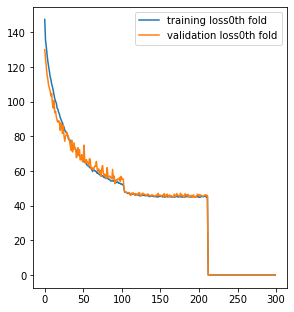

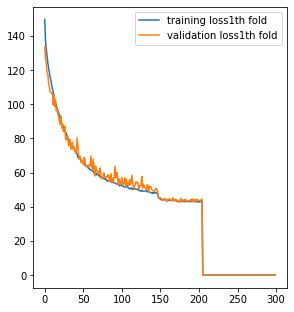

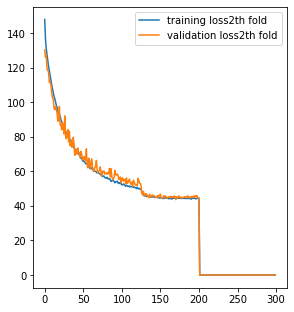

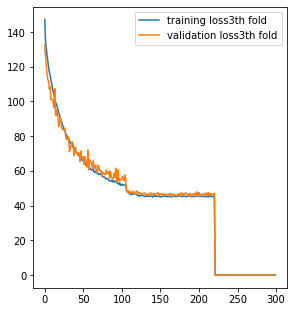

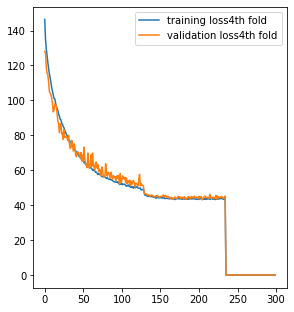

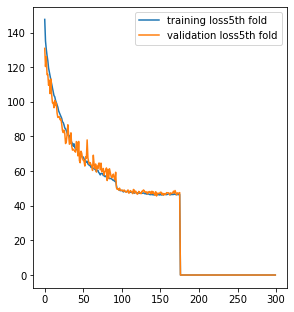

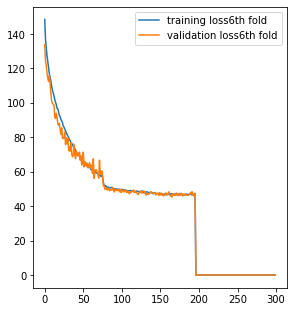

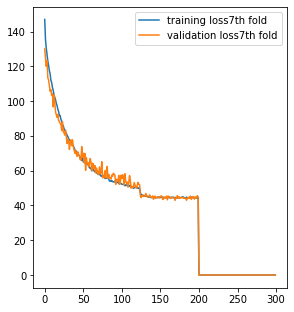

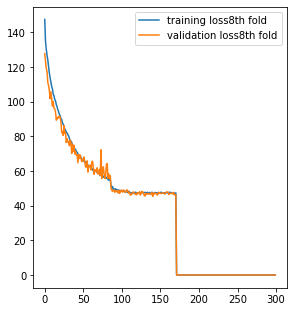

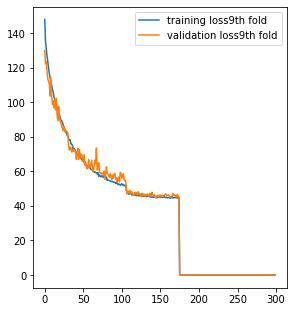

In [69]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_loss[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_loss[i], label = ('training loss' + str(i) + "th fold"))
    plt.plot(val_loss[i], label = ('validation loss'  + str(i) + "th fold"))

    plt.legend()

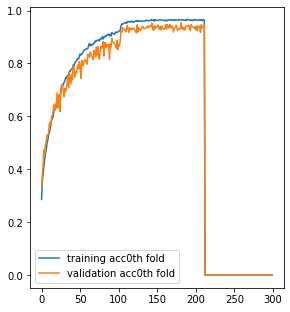

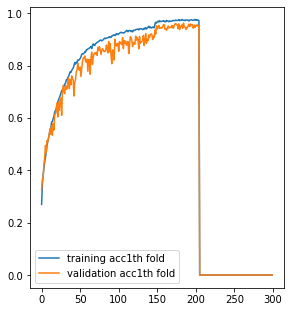

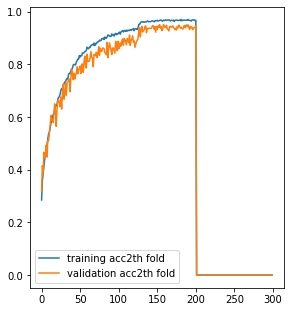

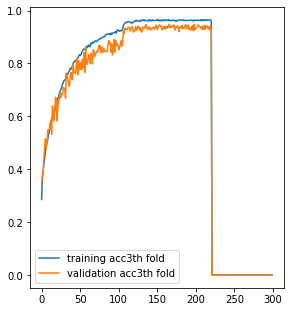

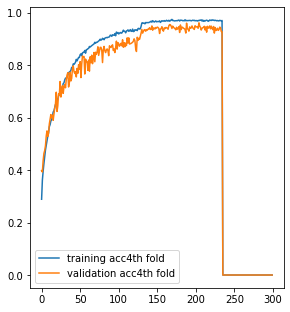

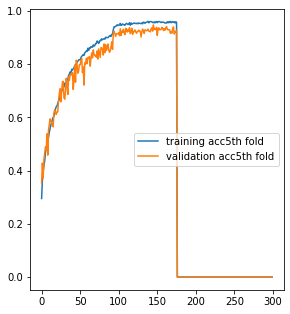

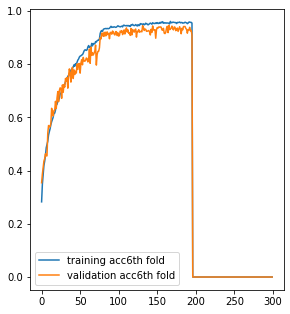

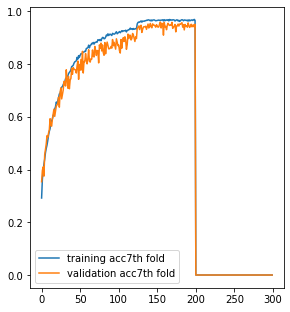

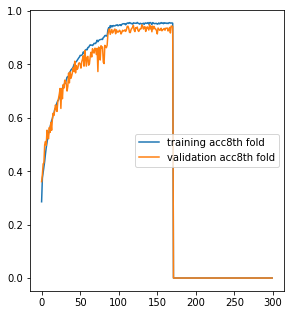

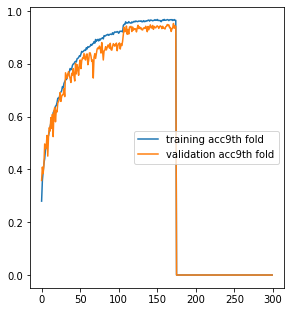

In [70]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_acc[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_acc[i], label = ('training acc' + str(i) + "th fold"))
    plt.plot(val_acc[i], label = ('validation acc'  + str(i) + "th fold"))

    plt.legend()

## Confusion Matrix 그리기

[[ 78.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [  0.  54.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0. 151.   2.   2.   0.   0.   2.   1.   4.   2.   1.   2.]
 [  0.   0.   2.  61.   0.   0.   0.   1.   0.   0.   1.   0.   5.]
 [  1.   0.   3.   0.  86.   0.   0.   1.   0.   2.   0.   3.   1.]
 [  0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.   0.   0.   1.   0.  55.   1.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   1.   0.   0.   0.  75.   0.   0.   0.   0.   0.]
 [  0.   1.   1.   0.   0.   0.   1.   0.  52.   1.   0.   0.   1.]
 [  0.   1.   5.   0.   0.   0.   0.   0.   3. 130.   0.   0.   2.]
 [  0.   0.   1.   0.   1.   0.   0.   0.   0.   1. 131.   0.   0.]
 [  0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.  79.   1.]
 [  0.   0.   5.   0.   1.   2.   1.   0.   1.   2.   0.   0. 198.]]
[[0.98734177 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.       

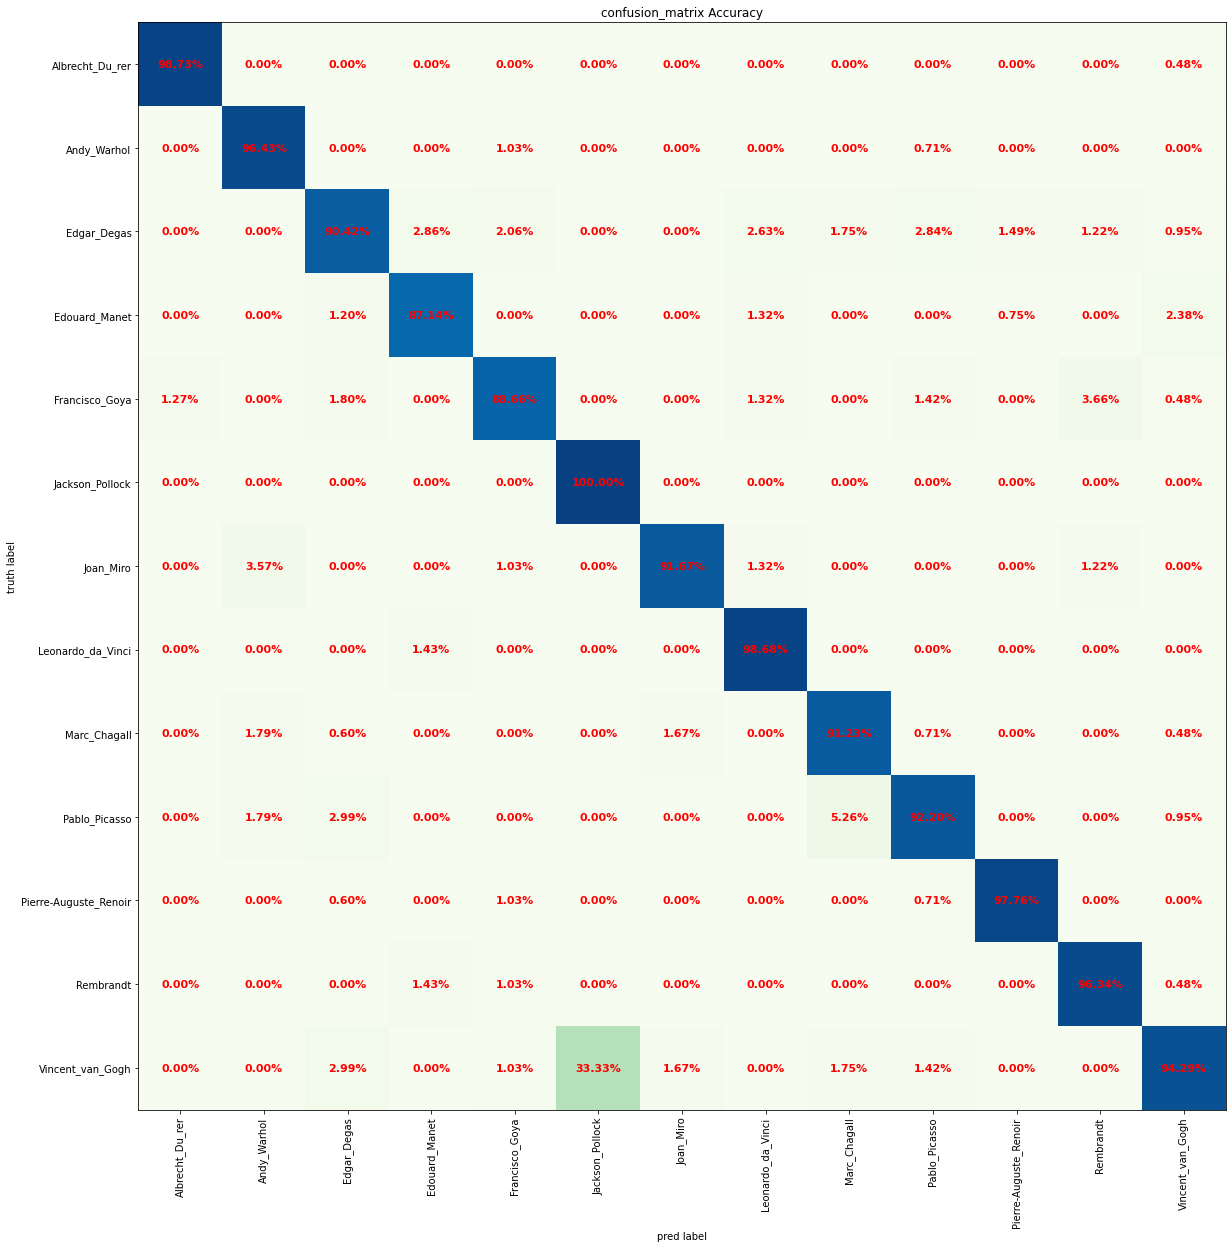

In [ ]:
confusion_matrix = np.zeros((13,13)) 
# 원래는 16x16을 사용합니다.(몬드리안을 2개로 분리해놨기 떄문) 
# #모네와 몬드리안을 빼고 학습하였을 때 다음과 같이 적용하였습니다.

model = Improve_ConvNet()
model = nn.DataParallel(model)
model.module.load_state_dict(torch.load('model_best_0.pt'))
model.to(device)

pred0 = []
propa0 = []

model.eval()
with torch.no_grad():
    for inputs, labels in valid_loader_kfold:
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model.forward(inputs)
        # Calculate accuracy
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)

        for c, l in zip(top_class, labels):
            # 중요한 부분, 모델이 예측한 가장 큰 확률을 가진 값 & 
            # 원래 Valid 값을 Confusion matrix에 넣어줌
            confusion_matrix[c[0].item()][l.item()] += 1

print(confusion_matrix)       
c = confusion_matrix/confusion_matrix.sum(axis=1) # c는 열별 합 -> 
# 원래 정답 클래스 합 -> 이걸 나눠서 하나의 pixel당 확률을 넣어주어 시각화를 함.
print(c)
plt.figure(figsize = (20,20))
plt.imshow((confusion_matrix/confusion_matrix.sum(axis=1)), cmap='GnBu')         
for (i, j), z in np.ndenumerate(c):
    # print(i, j, z)
    plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontsize=11, fontweight='bold')
    plt.title('confusion_matrix Accuracy')
    plt.xticks(np.arange(0, 13), classes, rotation = 90)
    plt.yticks(np.arange(0, 13), classes)
    plt.xlabel("pred label")
    plt.ylabel("truth label")

### ResNet 학습하기 (앙상블에 하나만 넣기)

In [ ]:
epochs = 400

train_loss = torch.zeros((k_fold, epochs))
val_loss = torch.zeros((k_fold, epochs))

train_acc = torch.zeros((k_fold, epochs))
val_acc = torch.zeros((k_fold, epochs))



for fold, (train_idx, val_idx) in enumerate(SKfold.split(train_data, train_data.targets)):
    print('Starting fold = ', fold)
    valid_loss_min = np.Inf
    cnt = 0
    total_cnt = 0

    if fold == 1: break  # 한번만 하고 끝내자.

    train_sampler_kfold = SubsetRandomSampler(train_idx)
    valid_sampler_kfold = SubsetRandomSampler(val_idx)

    batchsize = 64
    train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=train_sampler_kfold)
    valid_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=valid_sampler_kfold)

    # model = models.alexnet(pretrained=False)
    # model.fc = nn.Linear(512, 16)

    # from torchvision import models

    # model = models.resnet18(pretrained=False)
    # model.layer3 = nn.Sequential()
    # model.layer4 = nn.Sequential()
    # model.fc = nn.Linear(128, 16)

    # model.module.load_state_dict(torch.load("model_best_0.pt"))
    # model = ConvNet()
    # model = Improve_ConvNet()
    model = ResNet18()
    # model = AlexNet()
    # model = VGGM()
    model.initalize()

    # model = models.vgg16_bn(pretrained=True)

    #model = models.resnet18(pretrained=False)
    # model.fc = nn.Linear(512, 16)
    # model.classifier[6] = nn.Linear(4096, 16)
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    print(model)

    model.apply(reset_weights) # 파라미터 초기화.

    criterion = LabelSmoothingCrossEntropy(reduction='sum')
    
#    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.003)    
    optimizer = optim.AdamW(model.parameters(), lr = 0.00075)
    # optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay= 0.0001)
    # 참고 자료 https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1) -> 0.58
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    model.to(device)        

    for epoch in range(epochs):
        model.train()

        for inputs, labels in train_loader_kfold:
            
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            # loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()

            train_loss[fold][epoch] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
            
        train_loss[fold][epoch] /= len(train_loader_kfold)
        train_acc[fold][epoch] /= len(train_loader_kfold)

        
        model.eval()    
        with torch.no_grad():
            for inputs, labels in valid_loader_kfold:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model.forward(inputs)
                batch_loss = criterion(logits, labels)

                val_loss[fold][epoch] += batch_loss.item()

                # Calculate accuracy|
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
                # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
                
        val_loss[fold][epoch] /= len(valid_loader_kfold)
        val_acc[fold][epoch] /= len(valid_loader_kfold)

        print(f"{fold} Fold ---- Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_loss[fold][epoch]:.3f}.. "
            f"Train acc: {train_acc[fold][epoch]:.3f}.. "
            f"val loss: {val_loss[fold][epoch]:.3f}.. "
            f"val accuracy: {val_acc[fold][epoch]:.3f}")

        if val_loss[fold][epoch] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[fold][epoch]))
            # torch.save(model.state_dict(), 'model_best_' + str(fold) + '.pt')
            #DataParallel
            torch.save(model.module.state_dict(),'model_best_'+ str(fold) + '.pt')
            valid_loss_min = val_loss[fold][epoch]

            cnt = 0
            total_cnt = 0 

        if total_cnt >= 30:
            print("Early Stopping")
            break

    
        cnt+=1
        total_cnt+=1
        scheduler.step(val_loss[fold][epoch])

    ########################################################

Starting fold =  0
DataParallel(
  (module): ResNet18(
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1_BasicBlock0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer1_BasicBlock1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_sta

/tmp/ipykernel_32751/1629806097.py:129: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


0 Fold ---- Epoch 1/400.. Train loss: 151.624.. Train acc: 0.285.. val loss: 153.427.. val accuracy: 0.272
Validation loss decreased (inf --> 153.427109).  Saving model ...
0 Fold ---- Epoch 2/400.. Train loss: 137.823.. Train acc: 0.342.. val loss: 139.849.. val accuracy: 0.317
Validation loss decreased (153.427109 --> 139.848724).  Saving model ...
0 Fold ---- Epoch 3/400.. Train loss: 133.723.. Train acc: 0.371.. val loss: 126.834.. val accuracy: 0.377
Validation loss decreased (139.848724 --> 126.834122).  Saving model ...
0 Fold ---- Epoch 4/400.. Train loss: 131.907.. Train acc: 0.382.. val loss: 132.620.. val accuracy: 0.334
0 Fold ---- Epoch 5/400.. Train loss: 129.468.. Train acc: 0.390.. val loss: 126.540.. val accuracy: 0.389
Validation loss decreased (126.834122 --> 126.540237).  Saving model ...
0 Fold ---- Epoch 6/400.. Train loss: 127.033.. Train acc: 0.411.. val loss: 126.191.. val accuracy: 0.408
Validation loss decreased (126.540237 --> 126.191299).  Saving model ...


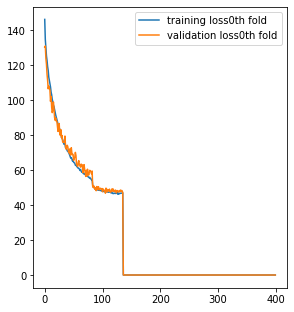

In [ ]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_loss[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_loss[i], label = ('training loss' + str(i) + "th fold"))
    plt.plot(val_loss[i], label = ('validation loss'  + str(i) + "th fold"))

    plt.legend()

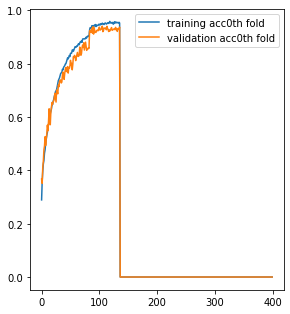

In [ ]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_acc[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_acc[i], label = ('training acc' + str(i) + "th fold"))
    plt.plot(val_acc[i], label = ('validation acc'  + str(i) + "th fold"))

    plt.legend()

--------------------------

## Step 6: Analyze the  training/validation results
+ 위에서 구한 학습 결과를 분석합니다. 
+ 수업에서 배운 그래프를 활용하시는 것을 적극 추천드립니다.
+ 만족할만한 결과가 나올 때 까지 Hyper Parameter Tuning을 진행합니다. 

## 모델 튜닝하기. 
- 1. 학습된 모델을 얼린 후 다시 한번 이어붙이기

In [ ]:
model = Improve_ConvNet()
# model = ResNet18()
model = nn.DataParallel(model)

### 얼리기 위해 Class 정의

In [208]:
class Conv_finetuning(nn.Module):  # Convolution Model Fine tuning
    def __init__(self,in_channel,featureExtract,class_num=16):
        super(Conv_finetuning, self).__init__() # 현재 모델 불러오기

        self.featureExtract = featureExtract # 기존 모델을 self로 넣어주기
        self.in_channel = in_channel       # 이어붙이는 모델의 채널

        # 이어붙일 ConvLayer1
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride = (1,1), padding= 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # 이어붙일 ConvLayer2
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride = (1,1), padding= 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        # 이어붙일 ConvLayer3
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride = (1,1), padding= 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )


        # 기존의 Linear Layer는 Identity 혹은 Sequential 로 막은 후 재 생성 
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608, 512),  
            nn.InstanceNorm1d(512),
            nn.ReLU(True),
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, class_num)
        )


    def forward(self,x):
        out = self.featureExtract(x) # 기존 모델 넣어주기
        # 마지막 채널 불러오기 -> Linear Layer를 거쳤기 때문에 2차원 -> 다시 3차원으로 늘려주기
        out = out.reshape(-1,self.in_channel,7,7) 
        # 마지막 Layer에 이어붙이기 ## Conv Model
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        # 다시 2차원으로 축소
        out = out.reshape(out.shape[0], -1)
        # Linear Layer 다시 재결합.
        out = self.fc1(out)
        out = self.fc2(out)
        

        return out

In [209]:
# model # 기존 모델의 형태 확인

In [210]:
model = Improve_ConvNet()
# for key,value in model.state_dict().items():
#     print(key)

in_feature = model.layer9[0].out_channels
in_feature

model.fc1 = nn.Identity()
model.fc3 = nn.Identity()

model1 = Conv_finetuning(in_channel=in_feature, featureExtract=model,class_num=16)
print(model1.state_dict().keys())

odict_keys(['featureExtract.layer1.0.weight', 'featureExtract.layer1.0.bias', 'featureExtract.layer1.1.weight', 'featureExtract.layer1.1.bias', 'featureExtract.layer1.1.running_mean', 'featureExtract.layer1.1.running_var', 'featureExtract.layer1.1.num_batches_tracked', 'featureExtract.layer2.0.weight', 'featureExtract.layer2.0.bias', 'featureExtract.layer2.1.weight', 'featureExtract.layer2.1.bias', 'featureExtract.layer2.1.running_mean', 'featureExtract.layer2.1.running_var', 'featureExtract.layer2.1.num_batches_tracked', 'featureExtract.layer3.0.weight', 'featureExtract.layer3.0.bias', 'featureExtract.layer3.1.weight', 'featureExtract.layer3.1.bias', 'featureExtract.layer3.1.running_mean', 'featureExtract.layer3.1.running_var', 'featureExtract.layer3.1.num_batches_tracked', 'featureExtract.layer4.0.weight', 'featureExtract.layer4.0.bias', 'featureExtract.layer4.1.weight', 'featureExtract.layer4.1.bias', 'featureExtract.layer4.1.running_mean', 'featureExtract.layer4.1.running_var', 'fe

In [211]:
# model과 새로 튜닝한 모델 비교
model, model1

(Improve_ConvNet(
   (layer1): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (layer2): Sequential(
     (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer3): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (layer4): Sequential(
     (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   

In [212]:
# torchsummary 모듈을 사용하여 학습이 되는지 확인.
from torchsummary import summary
summary(model1.cuda(),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
epochs = 300

train_loss = torch.zeros((k_fold, epochs))
val_loss = torch.zeros((k_fold, epochs))

train_acc = torch.zeros((k_fold, epochs))
val_acc = torch.zeros((k_fold, epochs))



for fold, (train_idx, val_idx) in enumerate(SKfold.split(train_data, train_data.targets)):
    print('Starting fold = ', fold)
    valid_loss_min = 65
    cnt = 0
    total_cnt = 0

    if fold == 1: break  # 그냥 돌리면 모델이 40퍼에서 학습이 안됌..


    train_sampler_kfold = SubsetRandomSampler(train_idx)
    valid_sampler_kfold = SubsetRandomSampler(val_idx)

    batchsize = 64
    train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=train_sampler_kfold)
    valid_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batchsize, sampler=valid_sampler_kfold)

    model = Improve_ConvNet()
    model = nn.DataParallel(model)

    model.module.load_state_dict(torch.load('model_best_2.pt'))

    model = Conv_finetuning(in_channels = in_feature, featureExtract=model,class_num=16)
    in_feature = model.layer9[0].out_channels
    model.featureExtract.module.fc1 = nn.Sequential()
    model.featureExtract.module.fc2 = nn.Sequential()
    model.featureExtract.module.fc3 = nn.Sequential()

    print(model)

    # if torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)
    # print(model)

    # model = ConvNet()
    # model.apply(reset_weights) # 파라미터 초기화.
    # model.initalize()
    
    criterion = LabelSmoothingCrossEntropy(reduction='sum')
    # optimizer = optim.Adam(model.parameters(), lr=0.003)    
    optimizer = optim.AdamW(model.parameters(), lr = 0.0075)
    # optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay= 0.0001)
    # 참고 자료 https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1) -> 0.58
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    model.to(device)        

    for epoch in range(epochs):
        model.train()

        for inputs, labels in train_loader_kfold:
            
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logits = model.forward(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss[fold][epoch] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
            
        train_loss[fold][epoch] /= len(train_loader_kfold)
        train_acc[fold][epoch] /= len(train_loader_kfold)

        
        model.eval()    
        with torch.no_grad():
            for inputs, labels in valid_loader_kfold:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model.forward(inputs)
                batch_loss = criterion(logits, labels)

                val_loss[fold][epoch] += batch_loss.item()

                # Calculate accuracy|
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_acc[fold][epoch] += torch.mean(equals.type(torch.FloatTensor)).item()
                # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
                
        val_loss[fold][epoch] /= len(valid_loader_kfold)
        val_acc[fold][epoch] /= len(valid_loader_kfold)

        print(f"{fold} Fold ---- Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {train_loss[fold][epoch]:.3f}.. "
            f"Train acc: {train_acc[fold][epoch]:.3f}.. "
            f"val loss: {val_loss[fold][epoch]:.3f}.. "
            f"val accuracy: {val_acc[fold][epoch]:.3f}")

        if val_loss[fold][epoch] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[fold][epoch]))
            # torch.save(model.state_dict(), 'model_best_' + str(fold) + '.pt')
            #DataParallel
            torch.save(model.state_dict(),'model_best_NEW'+ str(fold) + '.pt')
            valid_loss_min = val_loss[fold][epoch]

            cnt = 0
            total_cnt = 0 

        if total_cnt >= 30:
            print("Early Stopping")
            break

    
        cnt+=1
        total_cnt+=1
        scheduler.step(val_loss[fold][epoch])

    ########################################################

Starting fold =  0


/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Conv_finetuning(
  (featureExtract): DataParallel(
    (module): Improve_ConvNet(
      (layer1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (layer11): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (layer22): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

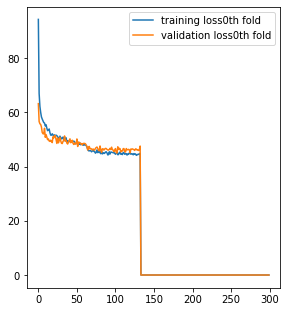

In [ ]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_loss[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_loss[i], label = ('training loss' + str(i) + "th fold"))
    plt.plot(val_loss[i], label = ('validation loss'  + str(i) + "th fold"))

    plt.legend()

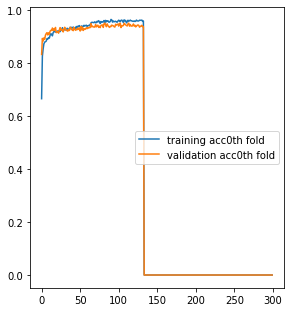

In [ ]:
import matplotlib.pyplot as plt

for i in range(k_fold):

    if train_acc[i][0] == 0:
        continue

    plt.figure(figsize = (10,30))
    
    plt.subplot(5, 2, i+1)
    plt.plot(train_acc[i], label = ('training acc' + str(i) + "th fold"))
    plt.plot(val_acc[i], label = ('validation acc'  + str(i) + "th fold"))

    plt.legend()

--------------------------

## Step 7: Define Test Data Set
> Test data를 위한 Custom Test Dataset을 제공해드립니다.   
> 필요한 부분을 채워 사용하시거나 직접 코드를 작성하셔도 됩니다.

In [15]:
'''Custom Dataset을 제작하기 위해서는 3가지를 반드시 포함해야합니다. 
1.def __init__()      :초기화 함수입니다. Dataset을 상속받아 imagepath와 transform을 지정합니다.
2.def __len__()       :dataset의 총 길이를 return하는 함수입니다. 
3.def __getitem__()   :index(idx)에 해당하는 data sample을 return 하는 함수입니다. 
'''
class test_Dataset(Dataset): #test_set을 class로 정의합니다.
    def __init__(self,imgpath,transform=None):
        
        self.imgpath = imgpath
        self.transform = transform
        
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self,idx):
        if self.transform !=None:
            x = self.transform(Image.open(self.imgpath[idx]).convert('RGB'))
        else: x = Image.open(self.imgpath[idx]).convert('RGB')
        return x

test_data_len: 834


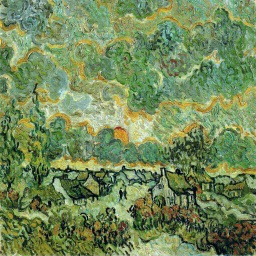

In [16]:
#예시 코드입니다. 잘 작동하는지 확인해봅시다.
# 저는 Test코드에 Albrecht_Du_rer로 폴더를 한번 더 감싸서 ImageLoader로 불러왔습니다.
# 기존의 코드가 동작을 하다 가끔씩 폴더 안에 데이터가 없다고 뜨는 오류가 몇번 발생하였습니다.
test_dir = './painting_resize_256/test/Albrecht_Du_rer/'
test_set  = sorted(glob.glob(test_dir+'/*'))
test_data = test_Dataset(test_set)

# 잘 불러오는지 확인해 봅시다. 
print("test_data_len:", test_data.__len__())
test_data.__getitem__(0)

In [17]:
test_dir = './painting_resize_256/test/Albrecht_Du_rer'
data_dir = "./painting_resize_256/"
test_transforms = transforms.Compose([
                                      # transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), # 똑같이 Normalize 수치 적용
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]),
                                    #   transforms.Normalize([0.5, 0.5, 0.5],
                                    #                        [0.5, 0.5, 0.5])
                                                           ])

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# testloader = torch.utils.data.DataLoader(test_data, batch_size=batchsize)

In [18]:
test_set  = sorted(glob.glob(test_dir+'/*')) #모든 파일을 읽어서 정리합니다. 
test_data = test_Dataset(test_set, test_transforms)

#Data Loader 작성 , (tip: test이므로 Shuffle을 할 필요가 없습니다. )
test_DataLoader = torch.utils.data.DataLoader(test_data, batch_size=64)

----------------

## Step 8(Final): Predict with Test Data
### Step 8-1: Predict 
+ test data를 우리의 모델로 예측합니다.

In [19]:
#class 재 확인 15개인지 확인하십시오  -> 몬드리안의 클래스를 의도적으로 늘려줌 Z_Piet_Mondrian_Sq 
#따라서 16개
print('Total Class num: ',class_num)
print('Class label:')
for i in range(class_num):print('{:5d}th : ' .format(i+1),classes[i])

Total Class num:  16
Class label:
    1th :  Albrecht_Du_rer
    2th :  Andy_Warhol
    3th :  Claude_Monet
    4th :  Edgar_Degas
    5th :  Edouard_Manet
    6th :  Francisco_Goya
    7th :  Jackson_Pollock
    8th :  Joan_Miro
    9th :  Leonardo_da_Vinci
   10th :  Marc_Chagall
   11th :  Pablo_Picasso
   12th :  Pierre-Auguste_Renoir
   13th :  Piet_Mondrian
   14th :  Rembrandt
   15th :  Vincent_van_Gogh
   16th :  Z_Piet_Mondrian_Sq


### 튜닝한 모델은 Load전 Conv_finetuning 클래스 적용시켜야 함. 

In [ ]:
# model = ConvNet()
# model = nn.DataParallel(model)
# model = Conv_finetuning(in_channels=in_features,featureExtract=model,class_num=16)
# model.featureExtract.module.fc1 = nn.Sequential()
# model.featureExtract.module.fc2 = nn.Sequential()

# model.load_state_dict(torch.load('model_best_0.pt'))
# DataParallel

### 그냥 학습시킨 모델의 경우 병렬처리 코드 넣어주기

In [20]:
model = Improve_ConvNet()
model = nn.DataParallel(model)

#최적의 모델 로드해서 predict를 진행합니다.

model.module.load_state_dict(torch.load('model_best_9.pt'))
model.eval()

### Hard Voting 혹은 Soft Voting 진행 

In [241]:
tmp = []; tmp_prop = []; tmp_prop_all = [] 
# tmp -> 예측값 하나만 가지고 진행 -> Hard Voting
# tmp_prop_all -> test 데이터에 대한 예측 확률 모두 조사 softamx() 거친 후 바로 저장
model.to(device)

for t in range(5):
    tmp = []; tmp_prop = []; tmp_prop_all = []    

    for data in test_DataLoader:
        if t == 0:
            model = Improve_ConvNet()
            print(model)
            model = nn.DataParallel(model)
            model.module.load_state_dict(torch.load('model_best_ConvNet_01.pt'))
            model.eval()

            pred0 = []; propa0 = []; prop0_all = []
            model.to(device)

        elif t == 1:
            model = Improve_ConvNet()
            model = nn.DataParallel(model)
            model.module.load_state_dict(torch.load('model_best_ConvNet_02.pt'))
            model.eval()

            pred1 = []; propa1 = []; prop1_all = []
            model.to(device)

        elif t == 2:
            model = Improve_ConvNet()
            model = nn.DataParallel(model)
            model.module.load_state_dict(torch.load('model_best_ConvNet_03.pt'))
            model.eval()

            pred2 = []; propa2 = []; prop2_all = []    
            model.to(device)

        elif t == 3:
            model = Improve_ConvNet()
            model = nn.DataParallel(model)
            model.module.load_state_dict(torch.load('model_best_ConvNet_04.pt'))
            model.eval()

            pred3 = []; propa3 = []; prop3_all = []
            model.to(device)

        elif t == 4:
            model = ResNet18()
            model = nn.DataParallel(model)
            model.module.load_state_dict(torch.load('model_best_ResNet18.pt'))
            model.eval()

            pred4 = []; propa4 = []; prop4_all = []   
            model.to(device)


        # print(data.shape)
        data = data.to(device)
        # model = model.cpu()
        logits = model(data)
        # logits = logits.cpu()
        ps = F.softmax(logits, dim=1).detach().clone()
        top_p, top_class = ps.topk(1, dim=1)
        tmp.append(top_class)
        tmp_prop.append(top_p)
        tmp_prop_all.append(ps)

        if t == 0:
            pred0 = tmp
            propa0 = tmp_prop
            prop0_all = tmp_prop_all

        elif t == 1:
            pred1 = tmp
            propa1 = tmp_prop
            prop1_all = tmp_prop_all
        
        elif t == 2:
            pred2 = tmp
            propa2 = tmp_prop
            prop2_all = tmp_prop_all
        elif t == 3:
            pred3 = tmp
            propa3 = tmp_prop
            prop3_all = tmp_prop_all
        elif t == 4:
            pred4 = tmp
            propa4 = tmp_prop            
            prop4_all = tmp_prop_all


Improve_ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer11): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer22): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(ker

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Improve_ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer11): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer22): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(ker

## Voting 제외 시 (단일 모델 사용시)

In [ ]:
# model.to(device)

# for data in test_DataLoader:
#     # print(data.shape)
#     data = data.to(device)
#     # model = model.cpu()
#     logits = model(data)
#     # logits = logits.cpu()
#     ps = F.softmax(logits, dim=1).detach().clone()
#     top_p, top_class = ps.topk(1, dim=1)
#     pred0.append(top_class)
#     # propa0.append(top_p)

# print(pred0)
# # print(voting)

## 5 fold hard voting

In [242]:
result = []
tmp = []

# 예측 라벨을 모두 반복문에 zip으로 해서 한번에 집어넣음
for one, two, three,four, five in zip(pred0, pred1, pred2, pred3, pred4):
    for o, t2, t3, f4, f5 in zip(one, two ,three, four, five):
        # tmp -> 다차원 인덱스 및 텐서 형태 모두 벗겨서 list로 저장 
        tmp = [o[0].item(), t2[0].item(), t3[0].item(), f4[0].item(), f5[0].item()]
        tmp_set = set(tmp) #  set은 중복 원소 포함 안함.
        
        # 다시 튜플로 변환
        tmp_tuple = tuple(tmp_set)
        
        # 만약 튜플의 길이가 1이다 -> 모든 모델이 하나의 그림을 예측
        if len(tmp_tuple) == 1:
            result.append(tmp_tuple[0]) # 바로 result에 추가

        # 튜플의 길이가 2일 경우에는? 5개 개준 3 2 혹은 4, 1로 나눠질 것.
        elif len(tmp_tuple) == 2:
            t_cnt = 0
            for t in tmp:
                 # 아까 list에 받은 tmp를 순회하며 3이상의 투표를 받은 친구를 result에 삽입
                if tmp_tuple[0] == t:
                    t_cnt +=1
            if t_cnt >= 3: result.append(tmp_tuple[0])
            else : result.append(tmp_tuple[1]) 

        # 튜플의 길이가 3일경우 조금 머리아파짐.
        # 1. (2 2 1,) (3 1 1) 이 있음
        elif len(tmp_tuple) == 3:
            t_cnt = 0
            t_cnt1 = 0
            t_cnt2 = 0
            for t in tmp:
                if tmp_tuple[0] == t:
                    t_cnt +=1
                elif tmp_tuple[1] == t:
                    t_cnt1 += 1
                elif tmp_tuple[2] == t:
                    t_cnt2 += 1

            # 튜플의 수가 3이니까 3개 모두 인덱스 달아서 몇개인지 비교
            # 2,2,1 일경우 먼저 들어온 친구 투표
            # 3 1 1 일경우 Max값으로 3인 클래스 투표
            if max(t_cnt, max(t_cnt1, t_cnt2)) == t_cnt: result.append(tmp_tuple[0])
            elif max(t_cnt, max(t_cnt1, t_cnt2)) == t_cnt1: result.append(tmp_tuple[1])
            elif max(t_cnt, max(t_cnt1, t_cnt2)) == t_cnt2: result.append(tmp_tuple[2])


        # 4일 경우에도 3과 비슷하게 진행 모두 꺼내서 크기가 2인 친구 투표
        elif len(tmp_tuple) == 4:
            t_cnt = 0
            t_cnt1 = 0
            t_cnt2 = 0
            t_cnt3 = 0
            for t in tmp:
                if tmp_tuple[0] == t:
                    t_cnt +=1
                elif tmp_tuple[1] == t:
                    t_cnt1 += 1
                elif tmp_tuple[2] == t:
                    t_cnt2 += 1
                elif tmp_tuple[3] == t:
                    t_cnt3 += 1

            
            if max(t_cnt, max(t_cnt1, max(t_cnt2, t_cnt3))) == t_cnt: result.append(tmp_tuple[0])
            elif max(t_cnt, max(t_cnt1,  max(t_cnt2, t_cnt3))) == t_cnt1: result.append(tmp_tuple[1])
            elif max(t_cnt, max(t_cnt1,  max(t_cnt2, t_cnt3))) == t_cnt2: result.append(tmp_tuple[2])
            elif max(t_cnt, max(t_cnt1,  max(t_cnt2, t_cnt3))) == t_cnt3: result.append(tmp_tuple[3])


        else:
            # 아무것도 예측이 없을 때.. 그냥 0번 째 값 넣기.
            # -> 원래라면 확률 비교해서 넣어야 하는데..
            result.append(tmp[0])
            print(tmp)

[11, 14, 13, 4, 10]
[11, 4, 14, 5, 10]


## Soft Voting 진행 

In [132]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf) # 출력 제한 없음.


result_propa = []
propa_count = 0 
for one, two, three,four, five in zip(prop0_all, prop1_all, prop2_all, prop3_all, prop4_all):
    for o, t2, t3, f4, f5 in zip(one, two ,three, four, five):         
        result_propa.append(o + t2 + t3 + f4 + f5) #확률 모두 더하기

result_propa

[tensor([0.0250, 0.0223, 0.0564, 0.0138, 0.0229, 0.0288, 0.0291, 0.0230, 0.0190,
         0.0143, 0.0547, 0.0106, 0.0226, 0.0179, 4.6152, 0.0243],
        device='cuda:0'),
 tensor([0.0495, 0.0540, 0.0559, 0.0366, 0.0647, 0.0635, 0.2701, 0.0537, 0.0728,
         0.0164, 2.3075, 0.0116, 0.0479, 0.0639, 1.8022, 0.0297],
        device='cuda:0'),
 tensor([4.6294, 0.0241, 0.0252, 0.0235, 0.0290, 0.0203, 0.0224, 0.0221, 0.0211,
         0.0291, 0.0276, 0.0253, 0.0263, 0.0397, 0.0081, 0.0268],
        device='cuda:0'),
 tensor([0.0285, 0.1582, 0.0203, 0.0072, 0.0211, 0.0358, 0.0261, 0.0326, 0.0435,
         0.0638, 4.0735, 0.0290, 0.0206, 0.0266, 0.3669, 0.0462],
        device='cuda:0'),
 tensor([0.1451, 0.0416, 0.0757, 0.0096, 0.0139, 0.0655, 0.0297, 0.0158, 0.1413,
         0.0332, 0.0452, 0.0266, 0.0451, 0.0297, 4.2007, 0.0812],
        device='cuda:0'),
 tensor([0.0183, 0.0150, 0.0159, 0.0074, 0.0174, 0.0179, 0.0158, 0.0211, 0.0137,
         0.0554, 4.7091, 0.0116, 0.0141, 0.0243, 0.022

In [133]:
soft_voting = []
for r in result_propa:
    print(r)
    # print(r.argmax().item())
    soft_voting.append(r.argmax().item()) # 그리고 똑같이 뽑기. 가장 높은 확률을 가지는 친구로 뽑아줘
    # top_p, top_class = r.(1, dim=1)
    # print(top_p, top_class)
    # print(r)
print(soft_voting)

tensor([0.0250, 0.0223, 0.0564, 0.0138, 0.0229, 0.0288, 0.0291, 0.0230, 0.0190,
        0.0143, 0.0547, 0.0106, 0.0226, 0.0179, 4.6152, 0.0243],
       device='cuda:0')
tensor([0.0495, 0.0540, 0.0559, 0.0366, 0.0647, 0.0635, 0.2701, 0.0537, 0.0728,
        0.0164, 2.3075, 0.0116, 0.0479, 0.0639, 1.8022, 0.0297],
       device='cuda:0')
tensor([4.6294, 0.0241, 0.0252, 0.0235, 0.0290, 0.0203, 0.0224, 0.0221, 0.0211,
        0.0291, 0.0276, 0.0253, 0.0263, 0.0397, 0.0081, 0.0268],
       device='cuda:0')
tensor([0.0285, 0.1582, 0.0203, 0.0072, 0.0211, 0.0358, 0.0261, 0.0326, 0.0435,
        0.0638, 4.0735, 0.0290, 0.0206, 0.0266, 0.3669, 0.0462],
       device='cuda:0')
tensor([0.1451, 0.0416, 0.0757, 0.0096, 0.0139, 0.0655, 0.0297, 0.0158, 0.1413,
        0.0332, 0.0452, 0.0266, 0.0451, 0.0297, 4.2007, 0.0812],
       device='cuda:0')
tensor([0.0183, 0.0150, 0.0159, 0.0074, 0.0174, 0.0179, 0.0158, 0.0211, 0.0137,
        0.0554, 4.7091, 0.0116, 0.0141, 0.0243, 0.0227, 0.0203],
       dev

In [134]:
result = soft_voting

### Step 8-2 : Making csv file with our predict result
+ csv파일로 만드는 예시를 보여드립니다. 

In [243]:
test_classes_num = {e:0 for e in classes} # train 데이터의 칼럼(작가) 별 갯수를 알아보기 위해 선언. Dictionary Comprehention사용.
test_classes_num

{'Albrecht_Du_rer': 0,
 'Andy_Warhol': 0,
 'Claude_Monet': 0,
 'Edgar_Degas': 0,
 'Edouard_Manet': 0,
 'Francisco_Goya': 0,
 'Jackson_Pollock': 0,
 'Joan_Miro': 0,
 'Leonardo_da_Vinci': 0,
 'Marc_Chagall': 0,
 'Pablo_Picasso': 0,
 'Pierre-Auguste_Renoir': 0,
 'Piet_Mondrian': 0,
 'Rembrandt': 0,
 'Vincent_van_Gogh': 0,
 'Z_Piet_Mondrian_Sq': 0}

### 앙상블사용시 result에 결과 저장

In [244]:
for i in range(test_data.__len__()):
    print(i, classes[result[i]])
    test_classes_num[classes[result[i]]] += 1

0 Vincent_van_Gogh
1 Pablo_Picasso
2 Albrecht_Du_rer
3 Pablo_Picasso
4 Vincent_van_Gogh
5 Pablo_Picasso
6 Leonardo_da_Vinci
7 Edgar_Degas
8 Rembrandt
9 Edgar_Degas
10 Francisco_Goya
11 Edgar_Degas
12 Claude_Monet
13 Rembrandt
14 Pablo_Picasso
15 Vincent_van_Gogh
16 Rembrandt
17 Edgar_Degas
18 Vincent_van_Gogh
19 Albrecht_Du_rer
20 Edgar_Degas
21 Edgar_Degas
22 Pablo_Picasso
23 Vincent_van_Gogh
24 Edgar_Degas
25 Edgar_Degas
26 Claude_Monet
27 Andy_Warhol
28 Marc_Chagall
29 Vincent_van_Gogh
30 Vincent_van_Gogh
31 Albrecht_Du_rer
32 Vincent_van_Gogh
33 Edgar_Degas
34 Joan_Miro
35 Francisco_Goya
36 Vincent_van_Gogh
37 Pablo_Picasso
38 Marc_Chagall
39 Pierre-Auguste_Renoir
40 Albrecht_Du_rer
41 Vincent_van_Gogh
42 Marc_Chagall
43 Rembrandt
44 Vincent_van_Gogh
45 Marc_Chagall
46 Albrecht_Du_rer
47 Albrecht_Du_rer
48 Edgar_Degas
49 Rembrandt
50 Pablo_Picasso
51 Andy_Warhol
52 Marc_Chagall
53 Leonardo_da_Vinci
54 Edgar_Degas
55 Joan_Miro
56 Edgar_Degas
57 Vincent_van_Gogh
58 Marc_Chagall
59 Re

### 일반 모델 사용시 classes에 저장

In [245]:
for i in range(test_data.__len__()):
    print(i, classes[pred0[i//64][i%64][0]])
    test_classes_num[classes[pred0[i//64][i%64][0]]] += 1

0 Vincent_van_Gogh
1 Vincent_van_Gogh
2 Albrecht_Du_rer
3 Pablo_Picasso
4 Vincent_van_Gogh
5 Pablo_Picasso
6 Leonardo_da_Vinci
7 Edgar_Degas
8 Rembrandt
9 Edgar_Degas
10 Francisco_Goya
11 Edgar_Degas
12 Claude_Monet
13 Rembrandt
14 Pablo_Picasso
15 Vincent_van_Gogh
16 Rembrandt
17 Edgar_Degas
18 Vincent_van_Gogh
19 Albrecht_Du_rer
20 Edgar_Degas
21 Edgar_Degas
22 Pablo_Picasso
23 Vincent_van_Gogh
24 Edgar_Degas
25 Edgar_Degas
26 Vincent_van_Gogh
27 Andy_Warhol
28 Marc_Chagall
29 Vincent_van_Gogh
30 Vincent_van_Gogh
31 Albrecht_Du_rer
32 Vincent_van_Gogh
33 Edgar_Degas
34 Joan_Miro
35 Edgar_Degas
36 Vincent_van_Gogh
37 Pablo_Picasso
38 Marc_Chagall
39 Pierre-Auguste_Renoir
40 Edgar_Degas
41 Francisco_Goya
42 Pablo_Picasso
43 Francisco_Goya
44 Vincent_van_Gogh
45 Marc_Chagall
46 Albrecht_Du_rer
47 Albrecht_Du_rer
48 Edgar_Degas
49 Rembrandt
50 Pablo_Picasso
51 Andy_Warhol
52 Marc_Chagall
53 Leonardo_da_Vinci
54 Edgar_Degas
55 Joan_Miro
56 Vincent_van_Gogh
57 Pierre-Auguste_Renoir
58 Marc

In [246]:
cnt_li = [66, 37, 15, 141, 18, 59, 5, 21, 29, 48, 88, 67, 17, 53, 176] #20% 리스트
test_result = {e:0 for e in classes}
for key, c in zip(test_result, cnt_li): test_result[key] = c

| 아흐 뒤러  | 262 | 262 / 0.8 * 0.2 = 65.5 | 65 ~ 66 |
| --- | --- | --- | --- |
| 앤디 워홀 | 145 | 145 / 0.8 * 0.2 = 36.25 | 35 ~ 37 | 
| 클라우드 모네 | 58 | 58 / 0.8 * 0.2 = 14.6 | 14 ~ 15 |
| 에드가 데가스 | 562 | 562 / 0.8 * 0.2 = 140.5 | 140 ~ 141 |
| 에두아르도 마네 | 72 | 72 / 0.8 * 0.2 = 18 | 18 |
| 프란체스코 고야 | 233| 233 / 0.8 * 0.2 = 58.25 | 58 ~ 59 |
| 잭슨 팔록 | 19 | 19 / 0.8 * 0.2 = 4.75 | 5 |
| 주앙 미로 | 82 | 82 / 0.8 * 0.2 = 20.5 | 20 ~ 21 |
| 레오나르도 다빈치 | 114 | 114 / 0.8 * 0.2 = 28.5 | 28 - 29 |
| 막 차질 | 191 | 191 / 0.8 * 0.2 = 47.75 | 47 ~ 48 |
| 파블로 피카소 | 351개 | 351 / 0.8 * 0.2 = 87.75 | 87 ~ 88 |
| 아우구스트 레누아  | 269개 | 269 / 0.8 * 0.2 = 67.75 | 67-68 |
| 피에 모드리안 | 67개 | 67 / 0.8 * 0.2 = 16.75 | 16 - 17 |
| 렘브란트 | 210개 | 210 / 0.8 * 0.2 = 52.5 | 52 - 53 |
| 빈센트 반 고흐 | 702개 | 702 / 0.8 * 0.2 = 175.5 | 175 ~ 176 |

In [247]:
test_gap = {e:(0,0) for e in classes}
for key, c in zip(test_result, cnt_li): 
    tmp_val = test_result[key] - test_classes_num[key]
    test_gap[key] = (tmp_val, round(tmp_val/test_result[key],4) * 100 ) 

In [248]:
test_classes_num

{'Albrecht_Du_rer': 131,
 'Andy_Warhol': 82,
 'Claude_Monet': 23,
 'Edgar_Degas': 288,
 'Edouard_Manet': 33,
 'Francisco_Goya': 109,
 'Jackson_Pollock': 8,
 'Joan_Miro': 35,
 'Leonardo_da_Vinci': 45,
 'Marc_Chagall': 87,
 'Pablo_Picasso': 188,
 'Pierre-Auguste_Renoir': 135,
 'Piet_Mondrian': 5,
 'Rembrandt': 110,
 'Vincent_van_Gogh': 382,
 'Z_Piet_Mondrian_Sq': 7}

In [249]:
test_gap

{'Albrecht_Du_rer': (-65, -98.48),
 'Andy_Warhol': (-45, -121.61999999999999),
 'Claude_Monet': (-8, -53.33),
 'Edgar_Degas': (-147, -104.25999999999999),
 'Edouard_Manet': (-15, -83.33),
 'Francisco_Goya': (-50, -84.75),
 'Jackson_Pollock': (-3, -60.0),
 'Joan_Miro': (-14, -66.67),
 'Leonardo_da_Vinci': (-16, -55.169999999999995),
 'Marc_Chagall': (-39, -81.25),
 'Pablo_Picasso': (-100, -113.64000000000001),
 'Pierre-Auguste_Renoir': (-68, -101.49),
 'Piet_Mondrian': (12, 70.59),
 'Rembrandt': (-57, -107.54999999999998),
 'Vincent_van_Gogh': (-206, -117.05000000000001),
 'Z_Piet_Mondrian_Sq': (0, 0)}

In [250]:
name=[]                                     # 그림의 Id를 담을 list 생성 
category =[]                                # 그림의 Category를 담을 list 생성
probability = []
for i in range(test_data.__len__()):        

    name.append(test_set[i].split('/')[-1]) # 파일 이름에서 label만 가지고 옵니다. 
    probability.append(propa0[i//64][i%64][0].item()) 

    # 일반 모델 사용시 이부분 주석 풀고 사용.
    # if classes[pred0[i//64][i%64][0]] == "Z_Piet_Mondrian_Sq" :
    #     category.append("Piet_Mondrian") 
    # else: category.append(classes[pred0[i//64][i%64][0]])       # pred에 해당하는 class를 category에 집어 넣습니다. 

    if classes[result[i]] == "Z_Piet_Mondrian_Sq" :
        category.append("Piet_Mondrian") 
    else: category.append(classes[result[i]])       # pred에 해당하는 class를 category에 집어 넣습니다. 
    
    
tm = localtime()
csv_file_name = f"{tm.tm_mday}day_{tm.tm_hour}h_{tm.tm_min}m_{tm.tm_sec}s"

#파일의 이름은 마음대로 설정할 수 있습니다. 경로를 쓰지 않으면 현재 디렉토리에 알아서 생성됩니다. 
pd.DataFrame({'Id':name,'Category':category}).to_csv(f'predict_{csv_file_name}.csv',index=False)    

#predict 하기 위해서 model 전체를 저장합니다. 체점을 위해서 필요한 과정입니다.
torch.save(model,f'.model_{csv_file_name}.pt')                                                 

In [251]:
print(name[:5])
print(category[:5])

['painting000.jpg', 'painting001.jpg', 'painting002.jpg', 'painting003.jpg', 'painting004.jpg']
['Vincent_van_Gogh', 'Pablo_Picasso', 'Albrecht_Du_rer', 'Pablo_Picasso', 'Vincent_van_Gogh']


In [252]:
# 잘 생성됬는지 확인 , 따로 경로를 설정하지 않았다면,현재 디렉토리에 자동으로 생성됩니다. 
csv = pd.read_csv(f'./predict_{csv_file_name}.csv')
csv

,Id,Category
0,painting000.jpg,Vincent_van_Gogh
1,painting001.jpg,Pablo_Picasso
2,painting002.jpg,Albrecht_Du_rer
3,painting003.jpg,Pablo_Picasso
4,painting004.jpg,Vincent_van_Gogh
...,...,...
829,painting829.jpg,Vincent_van_Gogh
830,painting830.jpg,Francisco_Goya
831,painting831.jpg,Pierre-Auguste_Renoir
832,painting832.jpg,Leonardo_da_Vinci


## 생성한 csv파일을 kaggle에 등록하시면 됩니다.

